# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


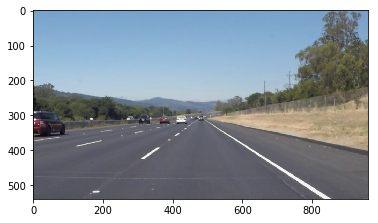

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    left_lane_slope_accumulator = 0
    left_lane_intercept_accumulator = 0
    left_lane_line_counter = 0
    right_lane_slope_accumulator = 0
    right_lane_intercept_accumulator = 0
    right_lane_line_counter = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1,x2],[y1,y2], 1)
            coeff, stats = np.polyfit([x1,x2],[y1,y2], 2)
            print ('coeff =', coeff)
            print ('stats =', stats)
#            print ('slope, intercept =', slope, ' ', intercept)
            if(((slope*slope) > 0.01) & ((slope*slope) < 100)):
                if(slope<0):
#                   left_lane_slope, left_lane_intercept = np.polyfit([x1,x2],[y1,y2], 1)
                    left_lane_slope_accumulator += slope
                    left_lane_intercept_accumulator += intercept
                    left_lane_line_counter += 1
                    """
                    print ('left side line =', line)
                    print ('left side slope accumulator =', left_lane_slope_accumulator)
                    print ('left_lane_intercept_accumulator =', left_lane_intercept_accumulator)
                    print ('left_lane_line_counter =', left_lane_line_counter)
                    print ('left slope intercept average =', (left_lane_slope_accumulator/left_lane_line_counter),\
                           (left_lane_intercept_accumulator/left_lane_line_counter))
                    """
                else:
#                   right_lane_slope, right_lane_intercept = np.polyfit([x1,x2],[y1,y2], 1)
                    right_lane_slope_accumulator += slope
                    right_lane_intercept_accumulator += intercept
                    right_lane_line_counter += 1
                    """
                    print ('right side line =', line)
                    print ('right side slope accumulator =', right_lane_slope_accumulator)
                    print ('right_lane_intercept_accumulator =', right_lane_intercept_accumulator)
                    print ('right_lane_line_counter =', right_lane_line_counter)
                    print ('right slope intercept average =', (right_lane_slope_accumulator/right_lane_line_counter), \
                           (right_lane_intercept_accumulator/right_lane_line_counter))
                    """
            else:
                print ('ignoring line ', line, ' due to bad slope ', slope, intercept)
#    print ('left lane counter =', left_lane_line_counter)
#    print ('right lane counter =', right_lane_line_counter)
    
    if(left_lane_line_counter !=0):
        left_lane_slope_average = left_lane_slope_accumulator/left_lane_line_counter
        left_lane_intercept_average = left_lane_intercept_accumulator/left_lane_line_counter
        left_lane_top_x = (330-left_lane_intercept_average)/left_lane_slope_average
        left_lane_bottom_x = (539-left_lane_intercept_average)/left_lane_slope_average
        cv2.line(img, (int(left_lane_bottom_x), 539), (int(left_lane_top_x), 330), color, thickness)
 
    if(right_lane_line_counter !=0):
        right_lane_slope_average = right_lane_slope_accumulator/right_lane_line_counter
        right_lane_intercept_average = right_lane_intercept_accumulator/right_lane_line_counter
        right_lane_top_x = (330-right_lane_intercept_average)/right_lane_slope_average
        right_lane_bottom_x = (539-right_lane_intercept_average)/right_lane_slope_average
        cv2.line(img, (int(right_lane_bottom_x), 539), (int(right_lane_top_x), 330), color, thickness)

    """
    print ('left_lane_slope_average =', left_lane_slope_average)
    print ('left_lane_intercept_average', left_lane_intercept_average)
    print ('right_lane_slope_average', right_lane_slope_average)
    print ('right_lane_intercept_average', right_lane_intercept_average)
    print ('left_lane_top_x =', left_lane_top_x)
    print ('left_lane_bottom_x =', left_lane_bottom_x)
    print ('right_lane_top_x =', right_lane_top_x)
    print ('right_lane_bottom_x =', right_lane_bottom_x)
    """
    
    
    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#    print ('line =', lines[0])
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['Output2_solidWhiteCurve.jpg',
 'Output2_solidWhiteRight.jpg',
 'Output2_solidYellowCurve.jpg',
 'Output2_solidYellowCurve2.jpg',
 'Output2_solidYellowLeft.jpg',
 'Output2_whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(input_image):
    print ("inside pipeline")
#    print ("input image")
#    plt.imshow(inImg)
    
    gaussian_kernel_size = 5  # kernel size used for gaussian blur
    canny_low_threshold = 50 # pixel with gradient below the low threshold are rejected
    canny_high_threshold = 150 # gradient used to detect strong edges
    vertices = np.array([[(420,330),(550,330),(920,539),(120,539)]],dtype=np.int32) # vertices of the masked area
#    vertices = np.array([[(420,340),(560,340),(920,539),(120,539)]],dtype=np.int32) # vertices of the masked area
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    
    grayscale_image = grayscale(input_image)
#    print ("gray image")
#    plt.imshow(grayscale_image, cmap='gray')

    gaussian_blurred_image = gaussian_blur (grayscale_image,gaussian_kernel_size)
#    print ("gaussian image")
#    plt.imshow(gaussian_blurred_image, cmap='gray')

    canny_image = canny(gaussian_blurred_image,canny_low_threshold,canny_high_threshold)
#    print ("canny image")
#    plt.imshow(canny_image, cmap='gray')

    masked_image = region_of_interest (canny_image,vertices)
#    print ("masked image")
#    plt.imshow(masked_image, cmap='gray')
#    plt.show()

    hough_image = hough_lines(masked_image,rho, theta, threshold, min_line_length, max_line_gap)
#    print ("hough image")
#    plt.imshow(hough_image, cmap='gray')

    weighted_image = weighted_img(hough_image, input_image)
#    print ("weighted image")
    plt.imshow(weighted_image)
    
    return weighted_image

"""

images = os.listdir('test_images/')

for image in images:
    
    if image[:8] != 'Output2_':
        input_image = mpimg.imread('test_images/%s' % image)
        print ('processing image ', image)
        output_image = pipeline (input_image)
        output_img_name = 'Output2_' + image
        print ('output image name =', output_img_name)
        mpimg.imsave('test_images/%s' % output_img_name,output_image)
    else:
        print ('ignoring image ', image)

"""

print ('dummy statement to make the above multiline comment work')

dummy statement to make the above multiline comment work


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

inside pipeline
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                                                                                                                                                                               | 0/222 [00:00<?, ?it/s]

inside pipeline
inside pipeline


  1%|█▊                                                                                                                                                                                                     | 2/222 [00:00<00:17, 12.81it/s]

inside pipeline
inside pipeline


  2%|███▌                                                                                                                                                                                                   | 4/222 [00:00<00:16, 12.88it/s]

inside pipeline


  2%|████▍                                                                                                                                                                                                  | 5/222 [00:00<00:18, 11.83it/s]

inside pipeline
inside pipeline


  3%|██████▎                                                                                                                                                                                                | 7/222 [00:00<00:17, 11.96it/s]

inside pipeline
inside pipeline


  4%|████████                                                                                                                                                                                               | 9/222 [00:00<00:17, 11.92it/s]

inside pipeline
inside pipeline


  5%|█████████▊                                                                                                                                                                                            | 11/222 [00:00<00:17, 11.91it/s]

inside pipeline
inside pipeline


  6%|███████████▌                                                                                                                                                                                          | 13/222 [00:01<00:16, 12.35it/s]

inside pipeline
inside pipeline


  7%|█████████████▍                                                                                                                                                                                        | 15/222 [00:01<00:16, 12.18it/s]

inside pipeline
inside pipeline


  8%|███████████████▏                                                                                                                                                                                      | 17/222 [00:01<00:16, 12.34it/s]

inside pipeline
inside pipeline


  9%|████████████████▉                                                                                                                                                                                     | 19/222 [00:01<00:16, 12.42it/s]

inside pipeline
inside pipeline


  9%|██████████████████▋                                                                                                                                                                                   | 21/222 [00:01<00:16, 12.38it/s]

inside pipeline
inside pipeline


 10%|████████████████████▌                                                                                                                                                                                 | 23/222 [00:01<00:15, 12.57it/s]

inside pipeline
inside pipeline


 11%|██████████████████████▎                                                                                                                                                                               | 25/222 [00:02<00:15, 12.70it/s]

inside pipeline
inside pipeline


 12%|████████████████████████                                                                                                                                                                              | 27/222 [00:02<00:15, 12.57it/s]

inside pipeline
inside pipeline


 13%|█████████████████████████▊                                                                                                                                                                            | 29/222 [00:02<00:15, 12.70it/s]

inside pipeline
inside pipeline


 14%|███████████████████████████▋                                                                                                                                                                          | 31/222 [00:02<00:15, 12.58it/s]

inside pipeline
inside pipeline


 15%|█████████████████████████████▍                                                                                                                                                                        | 33/222 [00:02<00:15, 12.34it/s]

inside pipeline
inside pipeline


 16%|███████████████████████████████▏                                                                                                                                                                      | 35/222 [00:02<00:14, 12.53it/s]

inside pipeline
inside pipeline


 17%|█████████████████████████████████                                                                                                                                                                     | 37/222 [00:02<00:14, 12.46it/s]

inside pipeline
inside pipeline


 18%|██████████████████████████████████▊                                                                                                                                                                   | 39/222 [00:03<00:15, 11.59it/s]

inside pipeline
inside pipeline


 18%|████████████████████████████████████▌                                                                                                                                                                 | 41/222 [00:03<00:16, 11.05it/s]

inside pipeline
inside pipeline


 19%|██████████████████████████████████████▎                                                                                                                                                               | 43/222 [00:03<00:16, 10.71it/s]

inside pipeline
inside pipeline


 20%|████████████████████████████████████████▏                                                                                                                                                             | 45/222 [00:03<00:16, 10.47it/s]

inside pipeline
inside pipeline


 21%|█████████████████████████████████████████▉                                                                                                                                                            | 47/222 [00:03<00:17, 10.22it/s]

inside pipeline
inside pipeline


 22%|███████████████████████████████████████████▋                                                                                                                                                          | 49/222 [00:04<00:15, 10.85it/s]

inside pipeline
inside pipeline


 23%|█████████████████████████████████████████████▍                                                                                                                                                        | 51/222 [00:04<00:15, 11.19it/s]

inside pipeline
inside pipeline


 24%|███████████████████████████████████████████████▎                                                                                                                                                      | 53/222 [00:04<00:14, 11.93it/s]

inside pipeline
inside pipeline


 25%|█████████████████████████████████████████████████                                                                                                                                                     | 55/222 [00:04<00:13, 12.72it/s]

inside pipeline
inside pipeline


 26%|██████████████████████████████████████████████████▊                                                                                                                                                   | 57/222 [00:04<00:12, 13.35it/s]

inside pipeline
inside pipeline


 27%|████████████████████████████████████████████████████▌                                                                                                                                                 | 59/222 [00:04<00:11, 13.77it/s]

inside pipeline
inside pipeline


 27%|██████████████████████████████████████████████████████▍                                                                                                                                               | 61/222 [00:04<00:11, 14.32it/s]

inside pipeline
inside pipeline


 28%|████████████████████████████████████████████████████████▏                                                                                                                                             | 63/222 [00:05<00:10, 15.21it/s]

inside pipeline
inside pipeline


 29%|█████████████████████████████████████████████████████████▉                                                                                                                                            | 65/222 [00:05<00:09, 15.74it/s]

inside pipeline
inside pipeline


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                          | 67/222 [00:05<00:09, 16.42it/s]

inside pipeline
inside pipeline


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                        | 69/222 [00:05<00:09, 16.89it/s]

inside pipeline
inside pipeline


 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                      | 71/222 [00:05<00:08, 17.25it/s]

inside pipeline
inside pipeline
inside pipeline


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 74/222 [00:05<00:08, 18.15it/s]

inside pipeline
inside pipeline
inside pipeline


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 77/222 [00:05<00:07, 18.81it/s]

inside pipeline
inside pipeline
inside pipeline


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                              | 80/222 [00:05<00:07, 19.58it/s]

inside pipeline
inside pipeline
inside pipeline


 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                            | 83/222 [00:06<00:06, 19.89it/s]

inside pipeline
inside pipeline
inside pipeline


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 86/222 [00:06<00:06, 20.66it/s]

inside pipeline
inside pipeline
inside pipeline


 40%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 89/222 [00:06<00:06, 21.72it/s]

inside pipeline
inside pipeline
inside pipeline


 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 92/222 [00:06<00:05, 22.43it/s]

inside pipeline
inside pipeline
inside pipeline


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 95/222 [00:06<00:05, 22.87it/s]

inside pipeline
inside pipeline
inside pipeline


 44%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 98/222 [00:06<00:05, 23.12it/s]

inside pipeline
inside pipeline
inside pipeline


 45%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 101/222 [00:06<00:05, 23.87it/s]

inside pipeline
inside pipeline
inside pipeline


 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 104/222 [00:06<00:04, 24.79it/s]

inside pipeline
inside pipeline
inside pipeline


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 107/222 [00:07<00:04, 25.45it/s]

inside pipeline
inside pipeline
inside pipeline


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 110/222 [00:07<00:04, 25.80it/s]

inside pipeline
inside pipeline
inside pipeline


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 113/222 [00:07<00:04, 25.85it/s]

inside pipeline
inside pipeline
inside pipeline


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 116/222 [00:07<00:04, 25.68it/s]

inside pipeline
inside pipeline
inside pipeline


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 119/222 [00:07<00:03, 25.79it/s]

inside pipeline
inside pipeline
inside pipeline


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 122/222 [00:07<00:04, 24.45it/s]

inside pipeline
inside pipeline
inside pipeline


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 125/222 [00:07<00:03, 25.52it/s]

inside pipeline
inside pipeline
inside pipeline


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 128/222 [00:07<00:03, 26.43it/s]

inside pipeline
inside pipeline
inside pipeline


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 131/222 [00:08<00:03, 25.26it/s]

inside pipeline
inside pipeline
inside pipeline


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 134/222 [00:08<00:03, 26.06it/s]

inside pipeline
inside pipeline
inside pipeline


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 137/222 [00:08<00:03, 24.89it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 141/222 [00:08<00:03, 26.32it/s]

inside pipeline
inside pipeline
inside pipeline


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 144/222 [00:08<00:03, 25.32it/s]

inside pipeline
inside pipeline
inside pipeline


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 147/222 [00:08<00:02, 25.63it/s]

inside pipeline
inside pipeline
inside pipeline


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 150/222 [00:08<00:03, 23.94it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 154/222 [00:08<00:02, 25.69it/s]

inside pipeline
inside pipeline
inside pipeline


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 157/222 [00:09<00:02, 26.85it/s]

inside pipeline
inside pipeline
inside pipeline


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 160/222 [00:09<00:02, 25.92it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 164/222 [00:09<00:02, 27.28it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 168/222 [00:09<00:01, 28.36it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 172/222 [00:09<00:01, 29.00it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 176/222 [00:09<00:01, 29.34it/s]

inside pipeline
inside pipeline
inside pipeline


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 179/222 [00:09<00:01, 29.53it/s]

inside pipeline
inside pipeline
inside pipeline


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 182/222 [00:09<00:01, 29.23it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 186/222 [00:09<00:01, 29.74it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 190/222 [00:10<00:01, 30.34it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 194/222 [00:10<00:00, 30.78it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 198/222 [00:10<00:00, 30.84it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 202/222 [00:10<00:00, 31.21it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 206/222 [00:10<00:00, 31.25it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 210/222 [00:10<00:00, 31.06it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 214/222 [00:10<00:00, 30.86it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 218/222 [00:11<00:00, 31.26it/s]

inside pipeline
inside pipeline
inside pipeline


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 221/222 [00:11<00:00, 19.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 12.1 s


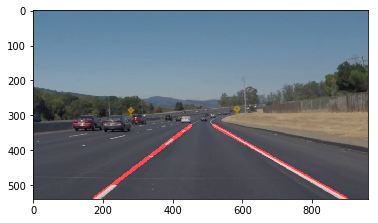

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

inside pipeline
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                                                                                                                                                                               | 0/682 [00:00<?, ?it/s]

inside pipeline
inside pipeline


  0%|▌                                                                                                                                                                                                      | 2/682 [00:00<00:54, 12.53it/s]

inside pipeline
inside pipeline


  1%|█▏                                                                                                                                                                                                     | 4/682 [00:00<00:54, 12.41it/s]

inside pipeline
inside pipeline


  1%|█▊                                                                                                                                                                                                     | 6/682 [00:00<00:54, 12.42it/s]

inside pipeline
inside pipeline


  1%|██▎                                                                                                                                                                                                    | 8/682 [00:00<00:54, 12.48it/s]

inside pipeline
inside pipeline


  1%|██▉                                                                                                                                                                                                   | 10/682 [00:00<00:53, 12.46it/s]

inside pipeline
inside pipeline


  2%|███▍                                                                                                                                                                                                  | 12/682 [00:00<00:54, 12.39it/s]

inside pipeline
inside pipeline


  2%|████                                                                                                                                                                                                  | 14/682 [00:01<00:55, 11.97it/s]

inside pipeline
inside pipeline


  2%|████▋                                                                                                                                                                                                 | 16/682 [00:01<00:55, 12.08it/s]

inside pipeline
inside pipeline


  3%|█████▏                                                                                                                                                                                                | 18/682 [00:01<00:54, 12.28it/s]

inside pipeline
inside pipeline


  3%|█████▊                                                                                                                                                                                                | 20/682 [00:01<00:54, 12.13it/s]

inside pipeline
inside pipeline


  3%|██████▍                                                                                                                                                                                               | 22/682 [00:01<00:52, 12.54it/s]

inside pipeline
inside pipeline


  4%|██████▉                                                                                                                                                                                               | 24/682 [00:01<00:53, 12.31it/s]

inside pipeline
inside pipeline


  4%|███████▌                                                                                                                                                                                              | 26/682 [00:02<00:52, 12.51it/s]

inside pipeline
inside pipeline


  4%|████████▏                                                                                                                                                                                             | 28/682 [00:02<00:50, 12.83it/s]

inside pipeline
inside pipeline


  4%|████████▋                                                                                                                                                                                             | 30/682 [00:02<00:48, 13.46it/s]

inside pipeline
inside pipeline


  5%|█████████▎                                                                                                                                                                                            | 32/682 [00:02<00:45, 14.21it/s]

inside pipeline
inside pipeline


  5%|█████████▊                                                                                                                                                                                            | 34/682 [00:02<00:43, 15.00it/s]

inside pipeline
inside pipeline


  5%|██████████▍                                                                                                                                                                                           | 36/682 [00:02<00:42, 15.06it/s]

inside pipeline
inside pipeline


  6%|███████████                                                                                                                                                                                           | 38/682 [00:02<00:46, 13.93it/s]

inside pipeline
inside pipeline


  6%|███████████▌                                                                                                                                                                                          | 40/682 [00:03<00:51, 12.45it/s]

inside pipeline
inside pipeline


  6%|████████████▏                                                                                                                                                                                         | 42/682 [00:03<00:55, 11.58it/s]

inside pipeline
inside pipeline


  6%|████████████▊                                                                                                                                                                                         | 44/682 [00:03<00:56, 11.34it/s]

inside pipeline
inside pipeline


  7%|█████████████▎                                                                                                                                                                                        | 46/682 [00:03<00:54, 11.61it/s]

inside pipeline
inside pipeline


  7%|█████████████▉                                                                                                                                                                                        | 48/682 [00:03<00:54, 11.57it/s]

inside pipeline
inside pipeline


  7%|██████████████▌                                                                                                                                                                                       | 50/682 [00:04<00:54, 11.69it/s]

inside pipeline
inside pipeline


  8%|███████████████                                                                                                                                                                                       | 52/682 [00:04<00:53, 11.80it/s]

inside pipeline
inside pipeline


  8%|███████████████▋                                                                                                                                                                                      | 54/682 [00:04<01:02, 10.07it/s]

inside pipeline
inside pipeline


  8%|████████████████▎                                                                                                                                                                                     | 56/682 [00:04<00:55, 11.19it/s]

inside pipeline
inside pipeline


  9%|████████████████▊                                                                                                                                                                                     | 58/682 [00:04<00:51, 12.22it/s]

inside pipeline
inside pipeline


  9%|█████████████████▍                                                                                                                                                                                    | 60/682 [00:04<00:47, 13.18it/s]

inside pipeline
inside pipeline


  9%|██████████████████                                                                                                                                                                                    | 62/682 [00:04<00:44, 13.97it/s]

inside pipeline
inside pipeline


  9%|██████████████████▌                                                                                                                                                                                   | 64/682 [00:05<00:41, 14.91it/s]

inside pipeline
inside pipeline


 10%|███████████████████▏                                                                                                                                                                                  | 66/682 [00:05<00:39, 15.66it/s]

inside pipeline
inside pipeline


 10%|███████████████████▋                                                                                                                                                                                  | 68/682 [00:05<00:37, 16.28it/s]

inside pipeline
inside pipeline


 10%|████████████████████▎                                                                                                                                                                                 | 70/682 [00:05<00:36, 16.66it/s]

inside pipeline
inside pipeline


 11%|████████████████████▉                                                                                                                                                                                 | 72/682 [00:05<00:34, 17.51it/s]

inside pipeline
inside pipeline
inside pipeline


 11%|█████████████████████▊                                                                                                                                                                                | 75/682 [00:05<00:33, 18.30it/s]

inside pipeline
inside pipeline
inside pipeline


 11%|██████████████████████▋                                                                                                                                                                               | 78/682 [00:05<00:31, 18.99it/s]

inside pipeline
inside pipeline
inside pipeline


 12%|███████████████████████▌                                                                                                                                                                              | 81/682 [00:05<00:30, 19.54it/s]

inside pipeline
inside pipeline
inside pipeline


 12%|████████████████████████▍                                                                                                                                                                             | 84/682 [00:06<00:29, 20.48it/s]

inside pipeline
inside pipeline
inside pipeline


 13%|█████████████████████████▎                                                                                                                                                                            | 87/682 [00:06<00:27, 21.44it/s]

inside pipeline
inside pipeline
inside pipeline


 13%|██████████████████████████▏                                                                                                                                                                           | 90/682 [00:06<00:26, 22.17it/s]

inside pipeline
inside pipeline
inside pipeline


 14%|██████████████████████████▉                                                                                                                                                                           | 93/682 [00:06<00:26, 22.61it/s]

inside pipeline
inside pipeline
inside pipeline


 14%|███████████████████████████▊                                                                                                                                                                          | 96/682 [00:06<00:25, 23.08it/s]

inside pipeline
inside pipeline
inside pipeline


 15%|████████████████████████████▋                                                                                                                                                                         | 99/682 [00:06<00:24, 23.82it/s]

inside pipeline
inside pipeline
inside pipeline


 15%|█████████████████████████████▍                                                                                                                                                                       | 102/682 [00:06<00:23, 24.36it/s]

inside pipeline
inside pipeline
inside pipeline


 15%|██████████████████████████████▎                                                                                                                                                                      | 105/682 [00:06<00:23, 24.76it/s]

inside pipeline
inside pipeline
inside pipeline


 16%|███████████████████████████████▏                                                                                                                                                                     | 108/682 [00:07<00:22, 25.23it/s]

inside pipeline
inside pipeline
inside pipeline


 16%|████████████████████████████████                                                                                                                                                                     | 111/682 [00:07<00:22, 25.28it/s]

inside pipeline
inside pipeline
inside pipeline


 17%|████████████████████████████████▉                                                                                                                                                                    | 114/682 [00:07<00:21, 25.98it/s]

inside pipeline
inside pipeline
inside pipeline


 17%|█████████████████████████████████▊                                                                                                                                                                   | 117/682 [00:07<00:21, 26.45it/s]

inside pipeline
inside pipeline
inside pipeline


 18%|██████████████████████████████████▋                                                                                                                                                                  | 120/682 [00:07<00:20, 26.94it/s]

inside pipeline
inside pipeline
inside pipeline


 18%|███████████████████████████████████▌                                                                                                                                                                 | 123/682 [00:07<00:20, 27.18it/s]

inside pipeline
inside pipeline
inside pipeline


 18%|████████████████████████████████████▍                                                                                                                                                                | 126/682 [00:07<00:20, 27.50it/s]

inside pipeline
inside pipeline
inside pipeline


 19%|█████████████████████████████████████▎                                                                                                                                                               | 129/682 [00:07<00:20, 27.50it/s]

inside pipeline
inside pipeline
inside pipeline


 19%|██████████████████████████████████████▏                                                                                                                                                              | 132/682 [00:07<00:19, 28.04it/s]

inside pipeline
inside pipeline
inside pipeline


 20%|██████████████████████████████████████▉                                                                                                                                                              | 135/682 [00:07<00:19, 28.52it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 20%|████████████████████████████████████████▏                                                                                                                                                            | 139/682 [00:08<00:18, 28.93it/s]

inside pipeline
inside pipeline
inside pipeline


 21%|█████████████████████████████████████████                                                                                                                                                            | 142/682 [00:08<00:18, 29.19it/s]

inside pipeline
inside pipeline
inside pipeline


 21%|█████████████████████████████████████████▉                                                                                                                                                           | 145/682 [00:08<00:18, 29.34it/s]

inside pipeline
inside pipeline
inside pipeline


 22%|██████████████████████████████████████████▊                                                                                                                                                          | 148/682 [00:08<00:18, 29.48it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 22%|███████████████████████████████████████████▉                                                                                                                                                         | 152/682 [00:08<00:17, 30.26it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 23%|█████████████████████████████████████████████                                                                                                                                                        | 156/682 [00:08<00:17, 30.54it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 23%|██████████████████████████████████████████████▏                                                                                                                                                      | 160/682 [00:08<00:16, 30.85it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 24%|███████████████████████████████████████████████▎                                                                                                                                                     | 164/682 [00:08<00:16, 31.00it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 25%|████████████████████████████████████████████████▌                                                                                                                                                    | 168/682 [00:09<00:16, 30.57it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 25%|█████████████████████████████████████████████████▋                                                                                                                                                   | 172/682 [00:09<00:16, 30.83it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 26%|██████████████████████████████████████████████████▊                                                                                                                                                  | 176/682 [00:09<00:16, 31.17it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 26%|███████████████████████████████████████████████████▉                                                                                                                                                 | 180/682 [00:09<00:16, 31.19it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 27%|█████████████████████████████████████████████████████▏                                                                                                                                               | 184/682 [00:09<00:15, 31.38it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 28%|██████████████████████████████████████████████████████▎                                                                                                                                              | 188/682 [00:09<00:15, 31.34it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 28%|███████████████████████████████████████████████████████▍                                                                                                                                             | 192/682 [00:09<00:15, 30.83it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 29%|████████████████████████████████████████████████████████▌                                                                                                                                            | 196/682 [00:09<00:15, 30.74it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                           | 200/682 [00:10<00:15, 30.63it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                          | 204/682 [00:10<00:15, 30.39it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 30%|████████████████████████████████████████████████████████████                                                                                                                                         | 208/682 [00:10<00:15, 30.46it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                       | 212/682 [00:10<00:15, 30.83it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                      | 216/682 [00:10<00:15, 30.95it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                     | 220/682 [00:10<00:14, 31.14it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                    | 224/682 [00:10<00:14, 31.24it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                   | 228/682 [00:11<00:14, 31.05it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 34%|███████████████████████████████████████████████████████████████████                                                                                                                                  | 232/682 [00:11<00:14, 31.11it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                                | 236/682 [00:11<00:14, 31.29it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                               | 240/682 [00:11<00:14, 31.20it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                              | 244/682 [00:11<00:14, 31.17it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                             | 248/682 [00:11<00:13, 31.19it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 252/682 [00:11<00:13, 31.31it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 256/682 [00:11<00:13, 31.21it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                          | 260/682 [00:12<00:13, 31.44it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 264/682 [00:12<00:13, 31.23it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 268/682 [00:12<00:13, 31.08it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 40%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 272/682 [00:12<00:13, 31.13it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 40%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 276/682 [00:12<00:12, 31.38it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 280/682 [00:12<00:12, 31.26it/s]

inside pipeline
inside pipeline
ignoring line  [[337 388 401 388]]  due to bad slope  0.0 388.0
inside pipeline
ignoring line  [[328 394 375 393]]  due to bad slope  -0.0212765957447 400.978723404
inside pipeline
ignoring line  [[320 400 389 400]]  due to bad slope  -6.77100655058e-16 400.0


 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 284/682 [00:12<00:13, 28.51it/s]

inside pipeline
ignoring line  [[315 403 380 403]]  due to bad slope  1.38197603123e-15 403.0
ignoring line  [[340 407 382 406]]  due to bad slope  -0.0238095238095 415.095238095
inside pipeline
ignoring line  [[314 413 373 414]]  due to bad slope  0.0169491525424 407.677966102
ignoring line  [[308 410 373 412]]  due to bad slope  0.0307692307692 400.523076923
inside pipeline
ignoring line  [[285 424 362 424]]  due to bad slope  1.23377766454e-16 424.0
ignoring line  [[313 421 359 421]]  due to bad slope  1.79020208267e-15 421.0


 42%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 287/682 [00:13<00:16, 24.35it/s]

inside pipeline
ignoring line  [[266 437 349 438]]  due to bad slope  0.0120481927711 433.795180723
ignoring line  [[278 434 349 436]]  due to bad slope  0.0281690140845 426.169014085
inside pipeline
ignoring line  [[243 453 326 455]]  due to bad slope  0.0240963855422 447.144578313
ignoring line  [[252 449 332 452]]  due to bad slope  0.0375 439.55
inside pipeline
ignoring line  [[263 475 311 475]]  due to bad slope  1.395629328e-15 475.0
ignoring line  [[220 472 305 472]]  due to bad slope  4.53459340225e-16 472.0


 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 290/682 [00:13<00:17, 22.00it/s]

inside pipeline
ignoring line  [[230 498 283 499]]  due to bad slope  0.0188679245283 493.660377358
ignoring line  [[229 501 280 503]]  due to bad slope  0.0392156862745 492.019607843
inside pipeline
ignoring line  [[157 533 214 534]]  due to bad slope  0.0175438596491 530.245614035
inside pipeline


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 293/682 [00:13<00:17, 21.87it/s]

inside pipeline
inside pipeline
inside pipeline


 43%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 296/682 [00:13<00:16, 23.03it/s]

inside pipeline
inside pipeline
inside pipeline


 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 299/682 [00:13<00:15, 24.69it/s]

inside pipeline
inside pipeline
inside pipeline


 44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 302/682 [00:13<00:14, 25.94it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 45%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 306/682 [00:13<00:13, 27.19it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 310/682 [00:13<00:13, 28.19it/s]

inside pipeline
inside pipeline
inside pipeline


 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 313/682 [00:13<00:13, 28.26it/s]

inside pipeline
inside pipeline
inside pipeline


 46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 316/682 [00:14<00:13, 28.07it/s]

inside pipeline
inside pipeline
inside pipeline


 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 319/682 [00:14<00:12, 28.13it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 323/682 [00:14<00:12, 28.68it/s]

inside pipeline
inside pipeline
inside pipeline


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 326/682 [00:14<00:12, 28.81it/s]

inside pipeline
inside pipeline
inside pipeline


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 329/682 [00:14<00:12, 28.81it/s]

inside pipeline
inside pipeline
inside pipeline


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 332/682 [00:14<00:12, 28.49it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 336/682 [00:14<00:11, 28.88it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 340/682 [00:14<00:11, 29.22it/s]

inside pipeline
inside pipeline
inside pipeline


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 343/682 [00:15<00:11, 28.85it/s]

inside pipeline
inside pipeline
inside pipeline


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 346/682 [00:15<00:11, 29.14it/s]

inside pipeline
inside pipeline
inside pipeline


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 349/682 [00:15<00:11, 28.75it/s]

inside pipeline
inside pipeline
inside pipeline


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 352/682 [00:15<00:11, 28.86it/s]

inside pipeline
inside pipeline
inside pipeline


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 355/682 [00:15<00:11, 28.89it/s]

inside pipeline
inside pipeline
inside pipeline


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 358/682 [00:15<00:11, 28.79it/s]

inside pipeline
inside pipeline
inside pipeline


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 361/682 [00:15<00:11, 28.59it/s]

inside pipeline
inside pipeline
inside pipeline


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 364/682 [00:15<00:11, 28.66it/s]

inside pipeline
inside pipeline
inside pipeline


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 367/682 [00:15<00:11, 28.51it/s]

inside pipeline
ignoring line  [[671 432 725 432]]  due to bad slope  -1.15084038307e-15 432.0
inside pipeline
ignoring line  [[697 448 748 446]]  due to bad slope  -0.0392156862745 475.333333333
inside pipeline


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 370/682 [00:15<00:11, 27.16it/s]

inside pipeline
inside pipeline
inside pipeline


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 373/682 [00:16<00:11, 27.76it/s]

inside pipeline
inside pipeline
inside pipeline


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 376/682 [00:16<00:10, 28.15it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 380/682 [00:16<00:10, 29.01it/s]

inside pipeline
inside pipeline
inside pipeline


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 383/682 [00:16<00:10, 29.12it/s]

inside pipeline
inside pipeline
inside pipeline


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 386/682 [00:16<00:10, 29.33it/s]

inside pipeline
inside pipeline
inside pipeline


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 389/682 [00:16<00:10, 29.09it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 393/682 [00:16<00:09, 29.64it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 397/682 [00:16<00:09, 29.93it/s]

inside pipeline
inside pipeline
inside pipeline


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 400/682 [00:17<00:09, 29.59it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 404/682 [00:17<00:09, 29.83it/s]

inside pipeline
inside pipeline
inside pipeline


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 407/682 [00:17<00:09, 29.56it/s]

inside pipeline
inside pipeline
inside pipeline


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 410/682 [00:17<00:09, 29.55it/s]

inside pipeline
inside pipeline
inside pipeline


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 413/682 [00:17<00:09, 29.42it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 417/682 [00:17<00:08, 29.84it/s]

inside pipeline
inside pipeline
inside pipeline


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 420/682 [00:17<00:08, 29.84it/s]

inside pipeline
inside pipeline
inside pipeline


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 423/682 [00:17<00:08, 29.57it/s]

inside pipeline
inside pipeline
inside pipeline


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 426/682 [00:17<00:08, 29.00it/s]

inside pipeline
inside pipeline
inside pipeline


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 429/682 [00:17<00:08, 28.99it/s]

inside pipeline
inside pipeline
inside pipeline


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 432/682 [00:18<00:08, 28.94it/s]

inside pipeline
inside pipeline
inside pipeline


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 435/682 [00:18<00:08, 29.24it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 439/682 [00:18<00:08, 29.55it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 443/682 [00:18<00:08, 29.83it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 447/682 [00:18<00:07, 29.83it/s]

inside pipeline
inside pipeline
inside pipeline


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 450/682 [00:18<00:07, 29.65it/s]

inside pipeline
inside pipeline
inside pipeline


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 453/682 [00:18<00:07, 29.53it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 457/682 [00:18<00:07, 30.16it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 461/682 [00:19<00:07, 30.43it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 465/682 [00:19<00:07, 30.63it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 469/682 [00:19<00:06, 30.63it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 473/682 [00:19<00:06, 30.74it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 477/682 [00:19<00:06, 30.12it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 481/682 [00:19<00:06, 29.73it/s]

inside pipeline
inside pipeline
inside pipeline


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 484/682 [00:19<00:06, 29.71it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 488/682 [00:19<00:06, 29.85it/s]

inside pipeline
inside pipeline
inside pipeline


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 491/682 [00:20<00:06, 29.62it/s]

inside pipeline
inside pipeline
inside pipeline


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 494/682 [00:20<00:06, 29.60it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 498/682 [00:20<00:06, 29.87it/s]

inside pipeline
inside pipeline
inside pipeline


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 501/682 [00:20<00:06, 29.20it/s]

inside pipeline
inside pipeline
inside pipeline


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 504/682 [00:20<00:06, 28.51it/s]

inside pipeline
inside pipeline
inside pipeline


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 507/682 [00:20<00:06, 28.52it/s]

inside pipeline
inside pipeline
inside pipeline


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 510/682 [00:20<00:05, 28.94it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 514/682 [00:20<00:05, 29.23it/s]

inside pipeline
inside pipeline
inside pipeline


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 517/682 [00:20<00:05, 28.65it/s]

inside pipeline
inside pipeline
inside pipeline


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 520/682 [00:21<00:05, 28.46it/s]

inside pipeline
inside pipeline
inside pipeline


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 523/682 [00:21<00:05, 28.17it/s]

inside pipeline
inside pipeline
inside pipeline


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 526/682 [00:21<00:05, 28.28it/s]

inside pipeline
inside pipeline
inside pipeline


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 529/682 [00:21<00:05, 28.48it/s]

inside pipeline
inside pipeline
inside pipeline


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 532/682 [00:21<00:05, 28.42it/s]

inside pipeline
inside pipeline
inside pipeline


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 535/682 [00:21<00:05, 28.42it/s]

inside pipeline
inside pipeline
inside pipeline


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 538/682 [00:21<00:05, 28.79it/s]

inside pipeline
inside pipeline
inside pipeline


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 541/682 [00:21<00:05, 28.15it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 545/682 [00:21<00:04, 28.79it/s]

inside pipeline
inside pipeline
inside pipeline


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 548/682 [00:22<00:04, 28.55it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 552/682 [00:22<00:04, 29.31it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 556/682 [00:22<00:04, 29.76it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 560/682 [00:22<00:04, 30.22it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 564/682 [00:22<00:04, 29.47it/s]

inside pipeline
inside pipeline
inside pipeline


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 567/682 [00:22<00:03, 29.58it/s]

inside pipeline
inside pipeline
inside pipeline


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 570/682 [00:22<00:03, 29.26it/s]

inside pipeline
inside pipeline
inside pipeline


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 573/682 [00:22<00:03, 29.26it/s]

inside pipeline
inside pipeline
inside pipeline


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 576/682 [00:22<00:03, 29.04it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 580/682 [00:23<00:03, 29.11it/s]

inside pipeline
inside pipeline
inside pipeline


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 583/682 [00:23<00:03, 29.15it/s]

inside pipeline
inside pipeline
inside pipeline


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 586/682 [00:23<00:03, 29.14it/s]

inside pipeline
inside pipeline
inside pipeline


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 589/682 [00:23<00:03, 28.14it/s]

inside pipeline
inside pipeline
inside pipeline


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 592/682 [00:23<00:03, 28.63it/s]

inside pipeline
inside pipeline
inside pipeline


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 595/682 [00:23<00:03, 28.90it/s]

inside pipeline
inside pipeline
inside pipeline


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 598/682 [00:23<00:02, 28.34it/s]

inside pipeline
inside pipeline
inside pipeline


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 601/682 [00:23<00:02, 28.65it/s]

inside pipeline
inside pipeline
inside pipeline


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 604/682 [00:23<00:02, 28.95it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 608/682 [00:24<00:02, 29.50it/s]

inside pipeline
inside pipeline
inside pipeline


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 611/682 [00:24<00:02, 29.29it/s]

inside pipeline
inside pipeline
inside pipeline


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 614/682 [00:24<00:02, 28.53it/s]

inside pipeline
inside pipeline
inside pipeline


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 617/682 [00:24<00:02, 28.25it/s]

inside pipeline
inside pipeline
inside pipeline


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 620/682 [00:24<00:02, 28.30it/s]

inside pipeline
inside pipeline
inside pipeline


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 623/682 [00:24<00:02, 28.26it/s]

inside pipeline
inside pipeline
inside pipeline


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 626/682 [00:24<00:01, 28.26it/s]

inside pipeline
inside pipeline
inside pipeline


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 629/682 [00:24<00:01, 28.27it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 633/682 [00:24<00:01, 28.75it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 637/682 [00:25<00:01, 29.32it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 641/682 [00:25<00:01, 29.64it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 645/682 [00:25<00:01, 30.27it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 649/682 [00:25<00:01, 29.47it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 653/682 [00:25<00:00, 29.81it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 657/682 [00:25<00:00, 30.32it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 661/682 [00:25<00:00, 30.11it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 665/682 [00:26<00:00, 29.95it/s]

inside pipeline
inside pipeline
inside pipeline


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 668/682 [00:26<00:00, 29.69it/s]

inside pipeline
inside pipeline
inside pipeline
inside pipeline


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 672/682 [00:26<00:00, 29.73it/s]

inside pipeline
ignoring line  [[668 449 721 449]]  due to bad slope  -7.51831242622e-16 449.0
inside pipeline
inside pipeline
ignoring line  [[729 496 803 493]]  due to bad slope  -0.0405405405405 525.554054054
ignoring line  [[789 491 832 489]]  due to bad slope  -0.046511627907 527.697674419


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 675/682 [00:26<00:00, 26.77it/s]

inside pipeline
ignoring line  [[852 528 896 525]]  due to bad slope  -0.0681818181818 586.090909091
ignoring line  [[774 529 853 524]]  due to bad slope  -0.0632911392405 577.987341772
inside pipeline
inside pipeline


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 678/682 [00:26<00:00, 26.38it/s]

inside pipeline
inside pipeline
inside pipeline


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [00:26<00:00, 27.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 27.7 s


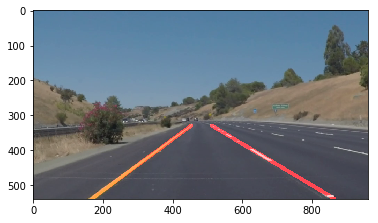

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

inside pipeline
ignoring line  [[259 442 524 424]]  due to bad slope  -0.0679245283019 459.59245283
ignoring line  [[253 446 569 424]]  due to bad slope  -0.0696202531646 463.613924051
ignoring line  [[621 420 676 420]]  due to bad slope  -5.57323802808e-16 420.0
ignoring line  [[592 419 654 416]]  due to bad slope  -0.0483870967742 447.64516129
ignoring line  [[343 432 413 428]]  due to bad slope  -0.0571428571429 451.6
ignoring line  [[403 379 479 379]]  due to bad slope  -3.63228783799e-16 379.0
ignoring line  [[262 445 319 441]]  due to bad slope  -0.0701754385965 463.385964912
ignoring line  [[373 433 456 430]]  due to bad slope  -0.0361445783133 446.481927711
ignoring line  [[400 377 477 377]]  due to bad slope  1.09574458471e-15 377.0
ignoring line  [[459 369 515 369]]  due to bad slope  2.05996389877e-15 369.0
ignoring line  [[342 434 433 428]]  due to bad slope  -0.0659340659341 456.549450549
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|                                                                                                                                                                                                               | 0/251 [00:00<?, ?it/s]

inside pipeline
ignoring line  [[259 442 524 424]]  due to bad slope  -0.0679245283019 459.59245283
ignoring line  [[253 446 569 424]]  due to bad slope  -0.0696202531646 463.613924051
ignoring line  [[621 420 676 420]]  due to bad slope  -5.57323802808e-16 420.0
ignoring line  [[592 419 654 416]]  due to bad slope  -0.0483870967742 447.64516129
ignoring line  [[343 432 413 428]]  due to bad slope  -0.0571428571429 451.6
ignoring line  [[403 379 479 379]]  due to bad slope  -3.63228783799e-16 379.0
ignoring line  [[262 445 319 441]]  due to bad slope  -0.0701754385965 463.385964912
ignoring line  [[373 433 456 430]]  due to bad slope  -0.0361445783133 446.481927711
ignoring line  [[400 377 477 377]]  due to bad slope  1.09574458471e-15 377.0
ignoring line  [[459 369 515 369]]  due to bad slope  2.05996389877e-15 369.0
ignoring line  [[342 434 433 428]]  due to bad slope  -0.0659340659341 456.549450549


  0%|▊                                                                                                                                                                                                      | 1/251 [00:00<01:40,  2.48it/s]

inside pipeline
ignoring line  [[450 428 690 415]]  due to bad slope  -0.0541666666667 452.375
ignoring line  [[488 428 684 418]]  due to bad slope  -0.0510204081633 452.897959184
ignoring line  [[338 431 473 431]]  due to bad slope  0.0 431.0
ignoring line  [[278 443 370 438]]  due to bad slope  -0.054347826087 458.108695652
ignoring line  [[328 435 375 435]]  due to bad slope  -1.36915518175e-15 435.0
ignoring line  [[278 441 410 428]]  due to bad slope  -0.0984848484848 468.378787879
ignoring line  [[369 433 431 434]]  due to bad slope  0.0161290322581 427.048387097
ignoring line  [[566 419 607 419]]  due to bad slope  1.02736154184e-15 419.0
ignoring line  [[377 375 474 375]]  due to bad slope  -3.75424454684e-16 375.0
ignoring line  [[491 429 534 427]]  due to bad slope  -0.046511627907 451.837209302
ignoring line  [[351 436 433 428]]  due to bad slope  -0.0975609756098 470.243902439
ignoring line  [[661 427 719 425]]  due to bad slope  -0.0344827586207 449.793103448
ignoring line

  1%|█▌                                                                                                                                                                                                     | 2/251 [00:00<01:48,  2.30it/s]

inside pipeline
ignoring line  [[262 445 632 420]]  due to bad slope  -0.0675675675676 462.702702703
ignoring line  [[458 427 687 415]]  due to bad slope  -0.0524017467249 451.0
ignoring line  [[296 440 430 429]]  due to bad slope  -0.0820895522388 464.298507463
ignoring line  [[352 432 418 428]]  due to bad slope  -0.0606060606061 453.333333333
ignoring line  [[344 437 463 427]]  due to bad slope  -0.0840336134454 465.907563025
ignoring line  [[338 432 387 429]]  due to bad slope  -0.0612244897959 452.693877551
ignoring line  [[672 427 712 423]]  due to bad slope  -0.1 494.2
ignoring line  [[455 428 596 420]]  due to bad slope  -0.0567375886525 453.815602837
ignoring line  [[377 372 418 371]]  due to bad slope  -0.0243902439024 381.195121951
ignoring line  [[385 434 447 432]]  due to bad slope  -0.0322580645161 446.419354839
ignoring line  [[404 377 474 377]]  due to bad slope  1.27777037587e-15 377.0
ignoring line  [[374 376 449 371]]  due to bad slope  -0.0666666666667 400.933333333

  1%|██▍                                                                                                                                                                                                    | 3/251 [00:01<01:41,  2.44it/s]

inside pipeline
ignoring line  [[259 442 674 413]]  due to bad slope  -0.0698795180723 460.098795181
ignoring line  [[253 446 630 420]]  due to bad slope  -0.0689655172414 463.448275862
ignoring line  [[316 435 439 427]]  due to bad slope  -0.0650406504065 455.552845528
ignoring line  [[373 375 470 375]]  due to bad slope  6.63146510513e-16 375.0
ignoring line  [[319 432 371 431]]  due to bad slope  -0.0192307692308 438.134615385
ignoring line  [[416 367 507 367]]  due to bad slope  6.06723735423e-16 367.0
ignoring line  [[406 431 515 423]]  due to bad slope  -0.0733944954128 460.798165138
ignoring line  [[662 422 702 421]]  due to bad slope  -0.025 438.55
ignoring line  [[320 442 484 431]]  due to bad slope  -0.0670731707317 463.463414634
ignoring line  [[529 424 578 422]]  due to bad slope  -0.0408163265306 445.591836735
ignoring line  [[329 435 434 431]]  due to bad slope  -0.0380952380952 447.533333333


  2%|███▏                                                                                                                                                                                                   | 4/251 [00:01<01:31,  2.69it/s]

inside pipeline
ignoring line  [[252 447 703 416]]  due to bad slope  -0.0687361419069 464.321507761
ignoring line  [[258 443 664 415]]  due to bad slope  -0.0689655172414 460.793103448
ignoring line  [[343 433 408 429]]  due to bad slope  -0.0615384615385 454.107692308
ignoring line  [[360 437 451 431]]  due to bad slope  -0.0659340659341 460.736263736
ignoring line  [[317 437 513 424]]  due to bad slope  -0.0663265306122 458.025510204
ignoring line  [[268 438 347 432]]  due to bad slope  -0.0759493670886 458.35443038
ignoring line  [[401 379 472 379]]  due to bad slope  9.17802809658e-17 379.0
ignoring line  [[348 432 429 429]]  due to bad slope  -0.037037037037 444.888888889
ignoring line  [[311 436 371 433]]  due to bad slope  -0.05 451.55


  2%|███▉                                                                                                                                                                                                   | 5/251 [00:01<01:22,  2.97it/s]

inside pipeline
ignoring line  [[258 447 703 416]]  due to bad slope  -0.0696629213483 464.973033708
ignoring line  [[256 444 672 415]]  due to bad slope  -0.0697115384615 461.846153846
ignoring line  [[374 432 426 429]]  due to bad slope  -0.0576923076923 453.576923077
ignoring line  [[304 436 393 430]]  due to bad slope  -0.0674157303371 456.494382022
ignoring line  [[392 379 442 375]]  due to bad slope  -0.08 410.36
ignoring line  [[417 368 504 368]]  due to bad slope  -8.68973455348e-17 368.0
ignoring line  [[313 438 399 432]]  due to bad slope  -0.0697674418605 459.837209302
ignoring line  [[599 409 640 406]]  due to bad slope  -0.0731707317073 452.829268293
ignoring line  [[377 434 447 430]]  due to bad slope  -0.0571428571429 455.542857143
ignoring line  [[596 421 644 418]]  due to bad slope  -0.0625 458.25


  2%|████▊                                                                                                                                                                                                  | 6/251 [00:02<01:17,  3.18it/s]

inside pipeline
ignoring line  [[614 422 702 416]]  due to bad slope  -0.0681818181818 463.863636364
ignoring line  [[256 444 685 414]]  due to bad slope  -0.0699300699301 461.902097902
ignoring line  [[255 447 541 427]]  due to bad slope  -0.0699300699301 464.832167832
ignoring line  [[300 434 476 428]]  due to bad slope  -0.0340909090909 444.227272727
ignoring line  [[302 437 363 433]]  due to bad slope  -0.0655737704918 456.803278689
ignoring line  [[414 429 471 428]]  due to bad slope  -0.0175438596491 436.263157895
ignoring line  [[300 436 433 431]]  due to bad slope  -0.0375939849624 447.278195489
ignoring line  [[396 377 440 374]]  due to bad slope  -0.0681818181818 404.0
ignoring line  [[252 447 540 427]]  due to bad slope  -0.0694444444444 464.5
ignoring line  [[322 433 390 430]]  due to bad slope  -0.0441176470588 447.205882353
ignoring line  [[394 379 464 373]]  due to bad slope  -0.0857142857143 412.771428571
ignoring line  [[402 379 456 374]]  due to bad slope  -0.09259259

  3%|█████▌                                                                                                                                                                                                 | 7/251 [00:02<01:14,  3.28it/s]

inside pipeline
ignoring line  [[252 447 699 416]]  due to bad slope  -0.0693512304251 464.476510067
ignoring line  [[259 443 671 414]]  due to bad slope  -0.0703883495146 461.230582524
ignoring line  [[296 437 397 430]]  due to bad slope  -0.0693069306931 457.514851485
ignoring line  [[303 437 421 429]]  due to bad slope  -0.0677966101695 457.542372881
ignoring line  [[256 444 473 429]]  due to bad slope  -0.0691244239631 461.695852535
ignoring line  [[294 436 342 432]]  due to bad slope  -0.0833333333333 460.5
ignoring line  [[406 368 451 368]]  due to bad slope  7.49387536665e-16 368.0
ignoring line  [[567 423 671 415]]  due to bad slope  -0.0769230769231 466.615384615
ignoring line  [[399 379 463 374]]  due to bad slope  -0.078125 410.171875
ignoring line  [[495 424 564 425]]  due to bad slope  0.0144927536232 416.826086957


  3%|██████▎                                                                                                                                                                                                | 8/251 [00:02<01:08,  3.53it/s]

inside pipeline
ignoring line  [[252 447 624 421]]  due to bad slope  -0.0698924731183 464.612903226
ignoring line  [[258 443 599 419]]  due to bad slope  -0.0703812316716 461.158357771
ignoring line  [[446 428 503 424]]  due to bad slope  -0.0701754385965 459.298245614
ignoring line  [[305 436 380 430]]  due to bad slope  -0.08 460.4
ignoring line  [[301 437 419 429]]  due to bad slope  -0.0677966101695 457.406779661
ignoring line  [[391 381 463 375]]  due to bad slope  -0.0833333333333 413.583333333
ignoring line  [[371 371 452 368]]  due to bad slope  -0.037037037037 384.740740741
ignoring line  [[300 434 342 432]]  due to bad slope  -0.047619047619 448.285714286
ignoring line  [[400 373 457 369]]  due to bad slope  -0.0701754385965 401.070175439


  4%|███████▏                                                                                                                                                                                               | 9/251 [00:02<01:03,  3.80it/s]

inside pipeline
ignoring line  [[252 447 634 421]]  due to bad slope  -0.0680628272251 464.151832461
ignoring line  [[260 443 636 417]]  due to bad slope  -0.0691489361702 460.978723404
ignoring line  [[442 429 503 425]]  due to bad slope  -0.0655737704918 457.983606557
ignoring line  [[292 439 339 435]]  due to bad slope  -0.0851063829787 463.85106383
ignoring line  [[306 435 379 430]]  due to bad slope  -0.0684931506849 455.95890411
ignoring line  [[256 444 478 429]]  due to bad slope  -0.0675675675676 461.297297297
ignoring line  [[417 367 491 367]]  due to bad slope  -7.94171595288e-16 367.0
ignoring line  [[390 382 462 376]]  due to bad slope  -0.0833333333333 414.5
ignoring line  [[373 432 422 429]]  due to bad slope  -0.0612244897959 454.836734694
ignoring line  [[347 433 406 429]]  due to bad slope  -0.0677966101695 456.525423729
ignoring line  [[284 436 341 432]]  due to bad slope  -0.0701754385965 455.929824561


  4%|███████▉                                                                                                                                                                                              | 10/251 [00:03<01:02,  3.84it/s]

inside pipeline
ignoring line  [[438 434 595 423]]  due to bad slope  -0.0700636942675 464.687898089
ignoring line  [[368 434 566 423]]  due to bad slope  -0.0555555555556 454.444444444
ignoring line  [[280 435 331 435]]  due to bad slope  -1.31113169885e-15 435.0
ignoring line  [[278 438 449 432]]  due to bad slope  -0.0350877192982 447.754385965
ignoring line  [[250 448 633 422]]  due to bad slope  -0.0678851174935 464.971279373
ignoring line  [[267 444 342 437]]  due to bad slope  -0.0933333333333 468.92
ignoring line  [[314 436 388 431]]  due to bad slope  -0.0675675675676 457.216216216
ignoring line  [[541 421 592 421]]  due to bad slope  7.79683649954e-16 421.0
ignoring line  [[255 445 478 429]]  due to bad slope  -0.0717488789238 463.295964126
ignoring line  [[386 381 460 376]]  due to bad slope  -0.0675675675676 407.081081081
ignoring line  [[400 368 494 368]]  due to bad slope  -4.47136541862e-16 368.0
ignoring line  [[368 372 432 372]]  due to bad slope  1.50248846547e-15 372

  4%|████████▋                                                                                                                                                                                             | 11/251 [00:03<01:03,  3.80it/s]

inside pipeline
ignoring line  [[408 436 596 423]]  due to bad slope  -0.0691489361702 464.212765957
ignoring line  [[504 426 633 417]]  due to bad slope  -0.0697674418605 461.162790698
ignoring line  [[335 441 418 436]]  due to bad slope  -0.0602409638554 461.180722892
ignoring line  [[379 436 558 421]]  due to bad slope  -0.0837988826816 467.759776536
ignoring line  [[436 429 497 424]]  due to bad slope  -0.0819672131148 464.737704918
ignoring line  [[362 437 445 429]]  due to bad slope  -0.0963855421687 471.891566265
ignoring line  [[273 439 326 435]]  due to bad slope  -0.0754716981132 459.603773585
ignoring line  [[589 419 715 427]]  due to bad slope  0.0634920634921 381.603174603
ignoring line  [[298 435 403 430]]  due to bad slope  -0.047619047619 449.19047619
ignoring line  [[269 437 346 432]]  due to bad slope  -0.0649350649351 454.467532468
ignoring line  [[261 446 302 444]]  due to bad slope  -0.0487804878049 458.731707317
ignoring line  [[347 438 387 434]]  due to bad slope

  5%|█████████▍                                                                                                                                                                                            | 12/251 [00:03<01:03,  3.74it/s]

inside pipeline
ignoring line  [[278 441 401 434]]  due to bad slope  -0.0569105691057 456.821138211
ignoring line  [[427 429 519 425]]  due to bad slope  -0.0434782608696 447.565217391
ignoring line  [[599 423 642 420]]  due to bad slope  -0.0697674418605 464.790697674
ignoring line  [[495 429 559 426]]  due to bad slope  -0.046875 452.203125
ignoring line  [[307 433 361 433]]  due to bad slope  2.39902247678e-16 433.0
ignoring line  [[412 435 494 430]]  due to bad slope  -0.0609756097561 460.12195122
ignoring line  [[254 446 357 440]]  due to bad slope  -0.0582524271845 460.796116505
ignoring line  [[286 435 395 430]]  due to bad slope  -0.045871559633 448.119266055
ignoring line  [[511 425 629 419]]  due to bad slope  -0.0508474576271 450.983050847
ignoring line  [[394 432 455 430]]  due to bad slope  -0.0327868852459 444.918032787
ignoring line  [[328 441 370 439]]  due to bad slope  -0.0476190476191 456.619047619
ignoring line  [[305 435 375 435]]  due to bad slope  -2.35194571582

  5%|██████████▎                                                                                                                                                                                           | 13/251 [00:03<01:08,  3.46it/s]

inside pipeline
ignoring line  [[520 423 646 416]]  due to bad slope  -0.0555555555556 451.888888889
ignoring line  [[268 440 443 430]]  due to bad slope  -0.0571428571429 455.314285714
ignoring line  [[253 446 597 422]]  due to bad slope  -0.0697674418605 463.651162791
ignoring line  [[272 434 409 429]]  due to bad slope  -0.036496350365 443.927007299
ignoring line  [[259 446 389 437]]  due to bad slope  -0.0692307692308 463.930769231
ignoring line  [[504 425 580 420]]  due to bad slope  -0.0657894736842 458.157894737
ignoring line  [[286 441 353 436]]  due to bad slope  -0.0746268656716 462.343283582
ignoring line  [[265 438 366 433]]  due to bad slope  -0.049504950495 451.118811881
ignoring line  [[586 418 671 422]]  due to bad slope  0.0470588235294 390.423529412
ignoring line  [[364 369 451 369]]  due to bad slope  -1.9615849642e-16 369.0
ignoring line  [[258 443 341 435]]  due to bad slope  -0.0963855421687 467.86746988
ignoring line  [[393 434 466 428]]  due to bad slope  -0.082

  6%|███████████                                                                                                                                                                                           | 14/251 [00:04<01:09,  3.42it/s]

inside pipeline
ignoring line  [[434 428 699 414]]  due to bad slope  -0.0528301886792 450.928301887
ignoring line  [[639 419 703 416]]  due to bad slope  -0.046875 448.953125
ignoring line  [[266 437 489 429]]  due to bad slope  -0.0358744394619 446.542600897
ignoring line  [[639 423 710 420]]  due to bad slope  -0.0422535211268 450.0
ignoring line  [[255 445 524 426]]  due to bad slope  -0.0706319702602 463.011152416
ignoring line  [[273 434 383 429]]  due to bad slope  -0.0454545454545 446.409090909
ignoring line  [[305 439 405 429]]  due to bad slope  -0.1 469.5
ignoring line  [[526 418 603 422]]  due to bad slope  0.0519480519481 390.675324675
ignoring line  [[259 442 360 433]]  due to bad slope  -0.0891089108911 465.079207921
ignoring line  [[542 420 590 423]]  due to bad slope  0.0625 386.125
ignoring line  [[365 368 416 368]]  due to bad slope  8.21694063973e-16 368.0
ignoring line  [[680 426 725 429]]  due to bad slope  0.0666666666667 380.666666667
ignoring line  [[390 375 45

  6%|███████████▊                                                                                                                                                                                          | 15/251 [00:04<01:09,  3.39it/s]

inside pipeline
ignoring line  [[538 425 634 418]]  due to bad slope  -0.0729166666667 464.229166667
ignoring line  [[257 445 531 426]]  due to bad slope  -0.0693430656934 462.821167883
ignoring line  [[494 425 626 416]]  due to bad slope  -0.0681818181818 458.681818182
ignoring line  [[334 438 486 424]]  due to bad slope  -0.0921052631579 468.763157895
ignoring line  [[267 438 346 433]]  due to bad slope  -0.0632911392405 454.898734177
ignoring line  [[264 442 394 429]]  due to bad slope  -0.1 468.4
ignoring line  [[271 434 368 431]]  due to bad slope  -0.0309278350515 442.381443299
ignoring line  [[374 435 547 420]]  due to bad slope  -0.0867052023121 467.427745665
ignoring line  [[382 365 424 365]]  due to bad slope  5.97616475481e-16 365.0
ignoring line  [[364 369 405 369]]  due to bad slope  7.30719173019e-16 369.0
ignoring line  [[289 433 387 429]]  due to bad slope  -0.0408163265306 444.795918367
ignoring line  [[580 424 634 421]]  due to bad slope  -0.0555555555556 456.22222222

  6%|████████████▌                                                                                                                                                                                         | 16/251 [00:04<01:07,  3.50it/s]

inside pipeline
ignoring line  [[255 445 622 419]]  due to bad slope  -0.0708446866485 463.065395095
ignoring line  [[265 440 647 413]]  due to bad slope  -0.0706806282723 458.730366492
ignoring line  [[311 433 371 429]]  due to bad slope  -0.0666666666667 453.733333333
ignoring line  [[417 433 581 421]]  due to bad slope  -0.0731707317073 463.512195122
ignoring line  [[585 417 628 414]]  due to bad slope  -0.0697674418605 457.813953488
ignoring line  [[503 424 697 414]]  due to bad slope  -0.0515463917526 449.927835052
ignoring line  [[589 416 646 412]]  due to bad slope  -0.0701754385965 457.333333333
ignoring line  [[630 431 691 427]]  due to bad slope  -0.0655737704918 472.31147541
ignoring line  [[380 365 425 365]]  due to bad slope  -9.97061179365e-17 365.0
ignoring line  [[265 438 374 429]]  due to bad slope  -0.0825688073394 459.880733945
ignoring line  [[378 363 419 364]]  due to bad slope  0.0243902439024 353.780487805
ignoring line  [[521 418 565 420]]  due to bad slope  0.0

  7%|█████████████▍                                                                                                                                                                                        | 17/251 [00:05<01:09,  3.39it/s]

inside pipeline
ignoring line  [[266 437 350 433]]  due to bad slope  -0.047619047619 449.666666667
ignoring line  [[256 445 584 423]]  due to bad slope  -0.0670731707317 462.170731707
ignoring line  [[260 442 626 416]]  due to bad slope  -0.0710382513661 460.469945355
ignoring line  [[275 436 377 429]]  due to bad slope  -0.0686274509804 454.87254902
ignoring line  [[582 420 711 424]]  due to bad slope  0.031007751938 401.953488372
ignoring line  [[373 431 420 428]]  due to bad slope  -0.063829787234 454.808510638
ignoring line  [[362 431 449 428]]  due to bad slope  -0.0344827586207 443.482758621
ignoring line  [[275 435 342 431]]  due to bad slope  -0.0597014925373 451.417910448
ignoring line  [[587 421 657 424]]  due to bad slope  0.0428571428571 395.842857143
ignoring line  [[311 441 364 437]]  due to bad slope  -0.0754716981132 464.471698113
ignoring line  [[661 417 704 417]]  due to bad slope  -1.53045478188e-15 417.0
ignoring line  [[276 440 374 432]]  due to bad slope  -0.0816

  7%|██████████████▏                                                                                                                                                                                       | 18/251 [00:05<01:03,  3.67it/s]

inside pipeline
ignoring line  [[255 445 580 423]]  due to bad slope  -0.0676923076923 462.261538462
ignoring line  [[262 441 644 415]]  due to bad slope  -0.0680628272251 458.832460733
ignoring line  [[266 439 345 434]]  due to bad slope  -0.0632911392405 455.835443038
ignoring line  [[271 434 446 428]]  due to bad slope  -0.0342857142857 443.291428571
ignoring line  [[615 422 723 428]]  due to bad slope  0.0555555555556 387.833333333
ignoring line  [[369 367 432 367]]  due to bad slope  1.00051480278e-15 367.0
ignoring line  [[585 418 653 420]]  due to bad slope  0.0294117647059 400.794117647
ignoring line  [[366 376 446 376]]  due to bad slope  7.88191133456e-16 376.0
ignoring line  [[651 423 698 422]]  due to bad slope  -0.0212765957447 436.85106383
ignoring line  [[424 428 475 426]]  due to bad slope  -0.0392156862745 444.62745098
ignoring line  [[594 420 693 414]]  due to bad slope  -0.0606060606061 456.0
ignoring line  [[320 438 418 432]]  due to bad slope  -0.0612244897959 457.

  8%|██████████████▉                                                                                                                                                                                       | 19/251 [00:05<01:00,  3.84it/s]

inside pipeline
ignoring line  [[269 435 441 429]]  due to bad slope  -0.0348837209302 444.38372093
ignoring line  [[445 432 630 422]]  due to bad slope  -0.0540540540541 456.054054054
ignoring line  [[632 426 685 424]]  due to bad slope  -0.0377358490566 449.849056604
ignoring line  [[267 441 622 417]]  due to bad slope  -0.0676056338028 459.050704225
ignoring line  [[649 431 699 430]]  due to bad slope  -0.02 443.98
ignoring line  [[387 436 456 432]]  due to bad slope  -0.0579710144928 458.434782609
ignoring line  [[584 420 626 420]]  due to bad slope  -2.05830648739e-15 420.0
ignoring line  [[281 437 349 437]]  due to bad slope  2.15669313248e-15 437.0
ignoring line  [[511 425 605 421]]  due to bad slope  -0.0425531914894 446.744680851
ignoring line  [[255 445 347 440]]  due to bad slope  -0.054347826087 458.858695652
ignoring line  [[577 415 621 415]]  due to bad slope  -3.68814799259e-15 415.0
ignoring line  [[367 367 425 367]]  due to bad slope  -7.08608901863e-16 367.0
ignoring 

  8%|███████████████▊                                                                                                                                                                                      | 20/251 [00:05<00:58,  3.97it/s]

inside pipeline
ignoring line  [[253 446 574 424]]  due to bad slope  -0.0685358255452 463.339563863
ignoring line  [[318 434 389 431]]  due to bad slope  -0.0422535211268 447.436619718
ignoring line  [[259 442 609 418]]  due to bad slope  -0.0685714285714 459.76
ignoring line  [[680 427 725 429]]  due to bad slope  0.0444444444444 396.777777778
ignoring line  [[489 430 571 425]]  due to bad slope  -0.0609756097561 459.817073171
ignoring line  [[556 422 628 420]]  due to bad slope  -0.0277777777778 437.444444444
ignoring line  [[302 434 342 432]]  due to bad slope  -0.05 449.1
ignoring line  [[475 426 527 426]]  due to bad slope  2.32349331129e-15 426.0
ignoring line  [[653 417 704 418]]  due to bad slope  0.0196078431373 404.196078431
ignoring line  [[573 418 625 419]]  due to bad slope  0.0192307692308 406.980769231
ignoring line  [[359 377 402 377]]  due to bad slope  3.16402269424e-15 377.0
ignoring line  [[376 367 469 367]]  due to bad slope  2.83690784489e-16 367.0
ignoring line 

  8%|████████████████▌                                                                                                                                                                                     | 21/251 [00:06<00:58,  3.96it/s]

inside pipeline
ignoring line  [[255 445 571 423]]  due to bad slope  -0.0696202531646 462.753164557
ignoring line  [[281 435 369 431]]  due to bad slope  -0.0454545454545 447.772727273
ignoring line  [[259 442 570 420]]  due to bad slope  -0.0707395498392 460.321543408
ignoring line  [[593 417 724 429]]  due to bad slope  0.0916030534351 362.679389313
ignoring line  [[549 426 681 417]]  due to bad slope  -0.0681818181818 463.431818182
ignoring line  [[648 425 703 429]]  due to bad slope  0.0727272727273 377.872727273
ignoring line  [[662 421 712 424]]  due to bad slope  0.06 381.28
ignoring line  [[264 439 329 435]]  due to bad slope  -0.0615384615385 455.246153846
ignoring line  [[577 412 618 415]]  due to bad slope  0.0731707317073 369.780487805
ignoring line  [[305 439 380 434]]  due to bad slope  -0.0666666666667 459.333333333
ignoring line  [[551 415 616 415]]  due to bad slope  2.13212867701e-15 415.0


  9%|█████████████████▎                                                                                                                                                                                    | 22/251 [00:06<00:56,  4.06it/s]

inside pipeline
ignoring line  [[253 446 545 426]]  due to bad slope  -0.0684931506849 463.328767123
ignoring line  [[554 423 680 417]]  due to bad slope  -0.047619047619 449.380952381
ignoring line  [[510 425 681 416]]  due to bad slope  -0.0526315789474 451.842105263
ignoring line  [[546 426 623 423]]  due to bad slope  -0.038961038961 447.272727273
ignoring line  [[261 441 486 426]]  due to bad slope  -0.0666666666667 458.4
ignoring line  [[349 433 398 430]]  due to bad slope  -0.0612244897959 454.367346939
ignoring line  [[271 438 348 432]]  due to bad slope  -0.0779220779221 459.116883117
ignoring line  [[291 440 391 433]]  due to bad slope  -0.07 460.37
ignoring line  [[678 431 726 429]]  due to bad slope  -0.0416666666667 459.25
ignoring line  [[591 416 660 421]]  due to bad slope  0.0724637681159 373.173913043


  9%|██████████████████▏                                                                                                                                                                                   | 23/251 [00:06<00:52,  4.31it/s]

inside pipeline
ignoring line  [[257 445 476 430]]  due to bad slope  -0.0684931506849 462.602739726
ignoring line  [[269 439 411 431]]  due to bad slope  -0.056338028169 454.154929577
ignoring line  [[532 426 663 421]]  due to bad slope  -0.0381679389313 446.305343511
ignoring line  [[624 421 706 418]]  due to bad slope  -0.0365853658537 443.829268293
ignoring line  [[330 434 370 432]]  due to bad slope  -0.05 450.5
ignoring line  [[392 431 679 416]]  due to bad slope  -0.0522648083624 451.487804878
ignoring line  [[287 435 343 432]]  due to bad slope  -0.0535714285714 450.375
ignoring line  [[403 431 464 426]]  due to bad slope  -0.0819672131148 464.032786885
ignoring line  [[296 440 343 436]]  due to bad slope  -0.0851063829787 465.191489362
ignoring line  [[508 423 558 424]]  due to bad slope  0.02 412.84
ignoring line  [[361 375 435 375]]  due to bad slope  1.00557275492e-16 375.0
ignoring line  [[517 427 586 425]]  due to bad slope  -0.0289855072464 441.985507246
ignoring line  [

 10%|██████████████████▉                                                                                                                                                                                   | 24/251 [00:06<00:55,  4.11it/s]

inside pipeline
ignoring line  [[582 421 679 415]]  due to bad slope  -0.0618556701031 457.0
ignoring line  [[477 429 603 424]]  due to bad slope  -0.0396825396825 447.928571429
ignoring line  [[260 441 635 415]]  due to bad slope  -0.0693333333333 459.026666667
ignoring line  [[281 442 385 436]]  due to bad slope  -0.0576923076923 458.211538462
ignoring line  [[272 434 340 433]]  due to bad slope  -0.0147058823529 438.0
ignoring line  [[390 431 460 426]]  due to bad slope  -0.0714285714286 458.857142857
ignoring line  [[587 423 643 424]]  due to bad slope  0.0178571428571 412.517857143
ignoring line  [[487 426 544 422]]  due to bad slope  -0.0701754385965 460.175438596
ignoring line  [[338 431 393 431]]  due to bad slope  4.38643810845e-16 431.0
ignoring line  [[268 437 327 435]]  due to bad slope  -0.0338983050847 446.084745763
ignoring line  [[597 421 678 416]]  due to bad slope  -0.0617283950617 457.851851852
ignoring line  [[623 426 691 423]]  due to bad slope  -0.0441176470588 45

 10%|███████████████████▋                                                                                                                                                                                  | 25/251 [00:07<00:57,  3.91it/s]

inside pipeline
ignoring line  [[386 435 655 421]]  due to bad slope  -0.0520446096654 455.089219331
ignoring line  [[273 436 362 432]]  due to bad slope  -0.0449438202247 448.269662921
ignoring line  [[260 441 377 433]]  due to bad slope  -0.0683760683761 458.777777778
ignoring line  [[620 421 704 418]]  due to bad slope  -0.0357142857143 443.142857143
ignoring line  [[462 428 560 421]]  due to bad slope  -0.0714285714286 461.0
ignoring line  [[263 444 364 438]]  due to bad slope  -0.0594059405941 459.623762376
ignoring line  [[584 420 676 417]]  due to bad slope  -0.0326086956522 439.043478261
ignoring line  [[581 393 658 398]]  due to bad slope  0.0649350649351 355.272727273
ignoring line  [[345 433 461 427]]  due to bad slope  -0.051724137931 450.844827586
ignoring line  [[681 430 726 429]]  due to bad slope  -0.0222222222222 445.133333333
ignoring line  [[586 394 661 399]]  due to bad slope  0.0666666666667 354.933333333


 10%|████████████████████▌                                                                                                                                                                                 | 26/251 [00:07<00:53,  4.18it/s]

inside pipeline
ignoring line  [[355 437 494 429]]  due to bad slope  -0.0575539568345 457.431654676
ignoring line  [[501 427 656 422]]  due to bad slope  -0.0322580645161 443.161290323
ignoring line  [[274 435 349 432]]  due to bad slope  -0.04 445.96
ignoring line  [[455 427 609 417]]  due to bad slope  -0.0649350649351 456.545454545
ignoring line  [[266 439 313 438]]  due to bad slope  -0.0212765957447 444.659574468
ignoring line  [[402 430 454 425]]  due to bad slope  -0.0961538461538 468.653846154
ignoring line  [[568 420 648 420]]  due to bad slope  -3.29832751383e-16 420.0
ignoring line  [[637 417 702 417]]  due to bad slope  -1.0194183098e-15 417.0
ignoring line  [[502 420 558 422]]  due to bad slope  0.0357142857143 402.071428571
ignoring line  [[593 419 658 424]]  due to bad slope  0.0769230769231 373.384615385
ignoring line  [[256 444 313 441]]  due to bad slope  -0.0526315789474 457.473684211
ignoring line  [[475 429 551 426]]  due to bad slope  -0.0394736842105 447.75
igno

 11%|█████████████████████▎                                                                                                                                                                                | 27/251 [00:07<00:54,  4.14it/s]

inside pipeline
ignoring line  [[365 436 617 422]]  due to bad slope  -0.0555555555556 456.277777778
ignoring line  [[309 435 663 416]]  due to bad slope  -0.0536723163842 451.584745763
ignoring line  [[355 433 664 417]]  due to bad slope  -0.0517799352751 451.381877023
ignoring line  [[618 434 669 433]]  due to bad slope  -0.0196078431373 446.117647059
ignoring line  [[617 426 700 422]]  due to bad slope  -0.0481927710843 455.734939759
ignoring line  [[618 424 658 421]]  due to bad slope  -0.075 470.35
ignoring line  [[262 440 331 440]]  due to bad slope  4.03962920145e-16 440.0
ignoring line  [[293 435 335 433]]  due to bad slope  -0.047619047619 448.952380952
ignoring line  [[621 433 725 429]]  due to bad slope  -0.0384615384615 456.884615385
ignoring line  [[618 427 668 425]]  due to bad slope  -0.04 451.72
ignoring line  [[256 445 370 436]]  due to bad slope  -0.0789473684211 465.210526316
ignoring line  [[610 396 653 396]]  due to bad slope  3.18060902849e-16 396.0
ignoring line 

 11%|██████████████████████                                                                                                                                                                                | 28/251 [00:07<00:53,  4.16it/s]

inside pipeline
ignoring line  [[318 439 477 430]]  due to bad slope  -0.0566037735849 457.0
ignoring line  [[487 428 653 422]]  due to bad slope  -0.0361445783133 445.602409639
ignoring line  [[509 425 663 417]]  due to bad slope  -0.0519480519481 451.441558442
ignoring line  [[554 419 605 415]]  due to bad slope  -0.078431372549 462.450980392
ignoring line  [[287 435 452 427]]  due to bad slope  -0.0484848484848 448.915151515
ignoring line  [[448 428 605 417]]  due to bad slope  -0.0700636942675 459.388535032
ignoring line  [[615 426 686 423]]  due to bad slope  -0.0422535211268 451.985915493
ignoring line  [[616 434 711 429]]  due to bad slope  -0.0526315789474 466.421052632
ignoring line  [[256 444 307 441]]  due to bad slope  -0.0588235294118 459.058823529
ignoring line  [[554 415 605 410]]  due to bad slope  -0.0980392156863 469.31372549
ignoring line  [[614 421 698 417]]  due to bad slope  -0.047619047619 450.238095238
ignoring line  [[553 416 598 412]]  due to bad slope  -0.088

 12%|██████████████████████▉                                                                                                                                                                               | 29/251 [00:07<00:53,  4.12it/s]

inside pipeline
ignoring line  [[334 438 479 430]]  due to bad slope  -0.0551724137931 456.427586207
ignoring line  [[480 426 661 417]]  due to bad slope  -0.0497237569061 449.867403315
ignoring line  [[405 430 529 425]]  due to bad slope  -0.0403225806452 446.330645161
ignoring line  [[260 441 314 436]]  due to bad slope  -0.0925925925926 465.074074074
ignoring line  [[507 429 655 421]]  due to bad slope  -0.0540540540541 456.405405405
ignoring line  [[390 431 444 427]]  due to bad slope  -0.0740740740741 459.888888889
ignoring line  [[533 424 684 424]]  due to bad slope  0.0 424.0
ignoring line  [[295 435 337 433]]  due to bad slope  -0.047619047619 449.047619048
ignoring line  [[358 373 427 379]]  due to bad slope  0.0869565217391 341.869565217
ignoring line  [[591 421 653 421]]  due to bad slope  -5.80869540834e-16 421.0
ignoring line  [[550 415 602 410]]  due to bad slope  -0.0961538461538 467.884615385
ignoring line  [[606 395 646 395]]  due to bad slope  -5.7757958359e-16 395.0


 12%|███████████████████████▋                                                                                                                                                                              | 30/251 [00:08<00:50,  4.35it/s]

inside pipeline
ignoring line  [[268 436 400 432]]  due to bad slope  -0.030303030303 444.121212121
ignoring line  [[339 439 496 429]]  due to bad slope  -0.0636942675159 460.592356688
ignoring line  [[571 424 627 424]]  due to bad slope  9.38409606829e-16 424.0
ignoring line  [[406 430 481 429]]  due to bad slope  -0.0133333333333 435.413333333
ignoring line  [[553 420 700 420]]  due to bad slope  -2.54880000273e-16 420.0
ignoring line  [[473 427 530 428]]  due to bad slope  0.0175438596491 418.701754386
ignoring line  [[581 425 637 427]]  due to bad slope  0.0357142857143 404.25
ignoring line  [[256 444 363 437]]  due to bad slope  -0.0654205607477 460.747663551
ignoring line  [[500 424 570 426]]  due to bad slope  0.0285714285714 409.714285714
ignoring line  [[475 426 551 427]]  due to bad slope  0.0131578947368 419.75
ignoring line  [[678 424 719 425]]  due to bad slope  0.0243902439024 407.463414634
ignoring line  [[551 416 614 422]]  due to bad slope  0.0952380952381 363.52380952

 12%|████████████████████████▍                                                                                                                                                                             | 31/251 [00:08<00:50,  4.34it/s]

inside pipeline
ignoring line  [[468 429 649 423]]  due to bad slope  -0.0331491712707 444.513812155
ignoring line  [[467 427 657 417]]  due to bad slope  -0.0526315789474 451.578947368
ignoring line  [[370 433 441 427]]  due to bad slope  -0.0845070422535 464.267605634
ignoring line  [[288 435 367 433]]  due to bad slope  -0.0253164556962 442.291139241
ignoring line  [[491 430 548 427]]  due to bad slope  -0.0526315789474 455.842105263
ignoring line  [[609 427 675 425]]  due to bad slope  -0.030303030303 445.454545455
ignoring line  [[611 428 662 426]]  due to bad slope  -0.0392156862745 451.960784314
ignoring line  [[654 432 729 431]]  due to bad slope  -0.0133333333333 440.72
ignoring line  [[269 442 315 440]]  due to bad slope  -0.0434782608696 453.695652174
ignoring line  [[564 423 630 419]]  due to bad slope  -0.0606060606061 457.181818182
ignoring line  [[568 424 633 422]]  due to bad slope  -0.0307692307692 441.476923077
ignoring line  [[414 434 471 430]]  due to bad slope  -0.

 13%|█████████████████████████▏                                                                                                                                                                            | 32/251 [00:08<00:50,  4.30it/s]

inside pipeline
ignoring line  [[259 443 458 432]]  due to bad slope  -0.0552763819095 457.316582915
ignoring line  [[459 431 581 426]]  due to bad slope  -0.0409836065574 449.81147541
ignoring line  [[435 430 656 418]]  due to bad slope  -0.0542986425339 453.619909502
ignoring line  [[484 425 591 420]]  due to bad slope  -0.0467289719626 447.61682243
ignoring line  [[358 434 439 429]]  due to bad slope  -0.0617283950617 456.098765432
ignoring line  [[461 427 656 417]]  due to bad slope  -0.0512820512821 450.641025641
ignoring line  [[318 435 374 432]]  due to bad slope  -0.0535714285714 452.035714286
ignoring line  [[614 422 688 428]]  due to bad slope  0.0810810810811 372.216216216
ignoring line  [[607 437 708 431]]  due to bad slope  -0.0594059405941 473.059405941
ignoring line  [[659 420 705 418]]  due to bad slope  -0.0434782608696 448.652173913
ignoring line  [[542 415 588 415]]  due to bad slope  -1.42163201639e-15 415.0
ignoring line  [[548 425 591 425]]  due to bad slope  -7.0

 13%|██████████████████████████                                                                                                                                                                            | 33/251 [00:08<00:48,  4.48it/s]

inside pipeline
ignoring line  [[266 437 374 433]]  due to bad slope  -0.037037037037 446.851851852
ignoring line  [[256 444 376 437]]  due to bad slope  -0.0583333333333 458.933333333
ignoring line  [[389 431 481 429]]  due to bad slope  -0.0217391304348 439.456521739
ignoring line  [[494 423 606 423]]  due to bad slope  -4.36228654589e-16 423.0
ignoring line  [[606 427 650 427]]  due to bad slope  1.66307781757e-15 427.0
ignoring line  [[452 428 514 426]]  due to bad slope  -0.0322580645161 442.580645161
ignoring line  [[536 428 603 424]]  due to bad slope  -0.0597014925373 460.0
ignoring line  [[545 421 653 421]]  due to bad slope  -4.67819987334e-16 421.0
ignoring line  [[678 432 730 432]]  due to bad slope  1.88282733814e-15 432.0
ignoring line  [[446 432 592 424]]  due to bad slope  -0.0547945205479 456.438356164
ignoring line  [[482 424 549 424]]  due to bad slope  -7.78074921942e-16 424.0
ignoring line  [[596 422 647 422]]  due to bad slope  6.46187886739e-17 422.0
ignoring lin

 14%|██████████████████████████▊                                                                                                                                                                           | 34/251 [00:09<00:48,  4.48it/s]

inside pipeline
ignoring line  [[425 434 620 424]]  due to bad slope  -0.0512820512821 455.794871795
ignoring line  [[265 438 314 436]]  due to bad slope  -0.0408163265306 448.816326531
ignoring line  [[496 428 638 419]]  due to bad slope  -0.0633802816901 459.436619718
ignoring line  [[430 431 519 424]]  due to bad slope  -0.0786516853933 464.820224719
ignoring line  [[603 429 663 427]]  due to bad slope  -0.0333333333333 449.1
ignoring line  [[271 444 328 440]]  due to bad slope  -0.0701754385965 463.01754386
ignoring line  [[322 436 426 429]]  due to bad slope  -0.0673076923077 457.673076923
ignoring line  [[592 419 646 419]]  due to bad slope  1.03796276905e-15 419.0
ignoring line  [[294 443 371 437]]  due to bad slope  -0.0779220779221 465.909090909
ignoring line  [[619 421 698 421]]  due to bad slope  -1.21859523962e-16 421.0
ignoring line  [[534 416 590 416]]  due to bad slope  -1.14290601077e-15 416.0
ignoring line  [[543 423 646 423]]  due to bad slope  -7.40939184326e-16 423.

 14%|███████████████████████████▌                                                                                                                                                                          | 35/251 [00:09<00:51,  4.18it/s]

inside pipeline
ignoring line  [[270 438 319 436]]  due to bad slope  -0.0408163265306 449.020408163
ignoring line  [[407 429 484 429]]  due to bad slope  -3.59552046523e-16 429.0
ignoring line  [[350 439 593 426]]  due to bad slope  -0.0534979423868 457.724279835
ignoring line  [[253 446 374 438]]  due to bad slope  -0.0661157024793 462.727272727
ignoring line  [[602 421 696 421]]  due to bad slope  -3.70626004612e-16 421.0
ignoring line  [[446 425 557 425]]  due to bad slope  -3.18647790042e-16 425.0
ignoring line  [[531 417 652 428]]  due to bad slope  0.0909090909091 368.727272727
ignoring line  [[540 421 644 428]]  due to bad slope  0.0673076923077 384.653846154
ignoring line  [[530 419 584 414]]  due to bad slope  -0.0925925925926 468.074074074
ignoring line  [[315 437 422 430]]  due to bad slope  -0.0654205607477 457.607476636
ignoring line  [[606 438 669 434]]  due to bad slope  -0.0634920634921 476.476190476
ignoring line  [[371 378 416 381]]  due to bad slope  0.0666666666667

 14%|████████████████████████████▍                                                                                                                                                                         | 36/251 [00:09<00:52,  4.06it/s]

inside pipeline
ignoring line  [[256 444 403 436]]  due to bad slope  -0.0544217687075 457.931972789
ignoring line  [[342 434 649 418]]  due to bad slope  -0.0521172638436 451.824104235
ignoring line  [[428 433 552 428]]  due to bad slope  -0.0403225806452 450.258064516
ignoring line  [[290 436 337 436]]  due to bad slope  -7.67117973904e-16 436.0
ignoring line  [[403 430 495 428]]  due to bad slope  -0.0217391304348 438.760869565
ignoring line  [[508 424 623 426]]  due to bad slope  0.0173913043478 415.165217391
ignoring line  [[672 425 722 427]]  due to bad slope  0.04 398.12
ignoring line  [[682 433 724 434]]  due to bad slope  0.0238095238095 416.761904762
ignoring line  [[598 429 671 426]]  due to bad slope  -0.041095890411 453.575342466
ignoring line  [[537 421 577 421]]  due to bad slope  -5.04810352842e-16 421.0
ignoring line  [[398 425 484 423]]  due to bad slope  -0.0232558139535 434.255813953
ignoring line  [[271 437 335 437]]  due to bad slope  -2.63842039813e-16 437.0
igno

 15%|█████████████████████████████▏                                                                                                                                                                        | 37/251 [00:09<00:53,  4.02it/s]

inside pipeline
ignoring line  [[265 438 641 418]]  due to bad slope  -0.0531914893617 452.095744681
ignoring line  [[667 421 708 419]]  due to bad slope  -0.0487804878049 453.536585366
ignoring line  [[256 444 418 435]]  due to bad slope  -0.0555555555556 458.222222222
ignoring line  [[419 434 509 430]]  due to bad slope  -0.0444444444444 452.622222222
ignoring line  [[596 428 638 428]]  due to bad slope  -6.5107141089e-17 428.0
ignoring line  [[564 423 641 423]]  due to bad slope  9.98652829413e-16 423.0
ignoring line  [[471 424 562 427]]  due to bad slope  0.032967032967 408.472527473
ignoring line  [[687 433 733 433]]  due to bad slope  3.96074726062e-16 433.0
ignoring line  [[524 416 630 416]]  due to bad slope  2.08106764985e-16 416.0
ignoring line  [[533 420 598 420]]  due to bad slope  -8.5152575091e-16 420.0
ignoring line  [[670 425 715 426]]  due to bad slope  0.0222222222222 410.111111111
ignoring line  [[398 423 501 427]]  due to bad slope  0.0388349514563 407.54368932
igno

 15%|█████████████████████████████▉                                                                                                                                                                        | 38/251 [00:10<00:51,  4.10it/s]

inside pipeline
ignoring line  [[437 433 577 426]]  due to bad slope  -0.05 454.85
ignoring line  [[466 426 625 418]]  due to bad slope  -0.0503144654088 449.446540881
ignoring line  [[274 437 640 418]]  due to bad slope  -0.051912568306 451.224043716
ignoring line  [[298 441 362 438]]  due to bad slope  -0.046875 454.96875
ignoring line  [[502 429 609 423]]  due to bad slope  -0.0560747663551 457.14953271
ignoring line  [[388 436 473 428]]  due to bad slope  -0.0941176470588 472.517647059
ignoring line  [[579 422 645 427]]  due to bad slope  0.0757575757576 378.136363636
ignoring line  [[617 420 693 420]]  due to bad slope  1.47029843157e-15 420.0
ignoring line  [[560 423 620 428]]  due to bad slope  0.0833333333333 376.333333333
ignoring line  [[521 415 603 415]]  due to bad slope  7.13306580579e-16 415.0
ignoring line  [[595 438 638 436]]  due to bad slope  -0.046511627907 465.674418605
ignoring line  [[555 396 628 402]]  due to bad slope  0.0821917808219 350.383561644


 16%|██████████████████████████████▊                                                                                                                                                                       | 39/251 [00:10<00:48,  4.33it/s]

inside pipeline
ignoring line  [[267 443 397 436]]  due to bad slope  -0.0538461538462 457.376923077
ignoring line  [[420 430 645 419]]  due to bad slope  -0.0488888888889 450.533333333
ignoring line  [[267 437 363 433]]  due to bad slope  -0.0416666666667 448.125
ignoring line  [[404 434 501 430]]  due to bad slope  -0.0412371134021 450.659793814
ignoring line  [[528 421 692 421]]  due to bad slope  1.95915007409e-16 421.0
ignoring line  [[593 439 671 434]]  due to bad slope  -0.0641025641026 477.012820513
ignoring line  [[476 424 559 427]]  due to bad slope  0.0361445783133 406.795180723
ignoring line  [[591 429 642 428]]  due to bad slope  -0.0196078431373 440.588235294
ignoring line  [[518 416 580 416]]  due to bad slope  -8.77168110159e-16 416.0
ignoring line  [[591 427 665 426]]  due to bad slope  -0.0135135135135 434.986486486
ignoring line  [[388 430 436 428]]  due to bad slope  -0.0416666666667 446.166666667
ignoring line  [[545 395 628 402]]  due to bad slope  0.0843373493976

 16%|███████████████████████████████▌                                                                                                                                                                      | 40/251 [00:10<00:50,  4.21it/s]

inside pipeline
ignoring line  [[337 439 394 436]]  due to bad slope  -0.0526315789474 456.736842105
ignoring line  [[263 439 389 432]]  due to bad slope  -0.0555555555556 453.611111111
ignoring line  [[414 435 582 426]]  due to bad slope  -0.0535714285714 457.178571429
ignoring line  [[599 423 708 419]]  due to bad slope  -0.0366972477064 444.981651376
ignoring line  [[386 434 609 419]]  due to bad slope  -0.067264573991 459.964125561
ignoring line  [[639 435 735 434]]  due to bad slope  -0.0104166666667 441.65625
ignoring line  [[255 445 379 437]]  due to bad slope  -0.0645161290323 461.451612903
ignoring line  [[473 424 528 424]]  due to bad slope  -2.24524930906e-15 424.0
ignoring line  [[265 438 416 430]]  due to bad slope  -0.0529801324503 452.039735099
ignoring line  [[669 425 722 427]]  due to bad slope  0.0377358490566 399.754716981
ignoring line  [[473 425 547 427]]  due to bad slope  0.027027027027 412.216216216


 16%|████████████████████████████████▎                                                                                                                                                                     | 41/251 [00:10<00:47,  4.42it/s]

inside pipeline
ignoring line  [[258 444 381 437]]  due to bad slope  -0.0569105691057 458.682926829
ignoring line  [[265 438 421 430]]  due to bad slope  -0.0512820512821 451.58974359
ignoring line  [[457 427 508 427]]  due to bad slope  -1.41420096483e-15 427.0
ignoring line  [[456 433 640 421]]  due to bad slope  -0.0652173913043 462.739130435
ignoring line  [[506 421 663 421]]  due to bad slope  -2.04465527826e-16 421.0
ignoring line  [[470 425 518 426]]  due to bad slope  0.0208333333333 415.208333333
ignoring line  [[419 435 476 431]]  due to bad slope  -0.0701754385965 464.403508772
ignoring line  [[510 415 553 415]]  due to bad slope  -1.43568939144e-15 415.0
ignoring line  [[506 422 599 424]]  due to bad slope  0.0215053763441 411.11827957
ignoring line  [[554 426 645 428]]  due to bad slope  0.021978021978 413.824175824
ignoring line  [[591 439 694 434]]  due to bad slope  -0.0485436893204 467.689320388
ignoring line  [[532 422 585 423]]  due to bad slope  0.0188679245283 411

 17%|█████████████████████████████████▏                                                                                                                                                                    | 42/251 [00:11<00:49,  4.21it/s]

inside pipeline
ignoring line  [[519 427 701 415]]  due to bad slope  -0.0659340659341 461.21978022
ignoring line  [[607 429 653 428]]  due to bad slope  -0.0217391304348 442.195652174
ignoring line  [[444 431 574 420]]  due to bad slope  -0.0846153846154 468.569230769
ignoring line  [[503 430 640 425]]  due to bad slope  -0.036496350365 448.357664234
ignoring line  [[673 435 736 435]]  due to bad slope  -1.70990412484e-15 435.0
ignoring line  [[287 437 336 436]]  due to bad slope  -0.0204081632653 442.857142857
ignoring line  [[344 440 495 425]]  due to bad slope  -0.0993377483444 474.17218543
ignoring line  [[661 419 708 419]]  due to bad slope  1.64321344457e-15 419.0
ignoring line  [[647 416 692 412]]  due to bad slope  -0.0888888888889 473.511111111
ignoring line  [[268 445 366 439]]  due to bad slope  -0.0612244897959 461.408163265
ignoring line  [[253 446 320 441]]  due to bad slope  -0.0746268656716 464.880597015
ignoring line  [[338 435 386 432]]  due to bad slope  -0.0625 456

 17%|█████████████████████████████████▉                                                                                                                                                                    | 43/251 [00:11<00:51,  4.05it/s]

inside pipeline
ignoring line  [[278 443 532 429]]  due to bad slope  -0.0551181102362 458.322834646
ignoring line  [[451 429 620 420]]  due to bad slope  -0.0532544378698 453.017751479
ignoring line  [[498 430 633 425]]  due to bad slope  -0.037037037037 448.444444444
ignoring line  [[334 437 411 433]]  due to bad slope  -0.0519480519481 454.350649351
ignoring line  [[272 440 385 432]]  due to bad slope  -0.070796460177 459.256637168
ignoring line  [[263 439 370 432]]  due to bad slope  -0.0654205607477 456.205607477
ignoring line  [[557 426 705 418]]  due to bad slope  -0.0540540540541 456.108108108
ignoring line  [[372 436 430 431]]  due to bad slope  -0.0862068965517 468.068965517
ignoring line  [[674 435 723 435]]  due to bad slope  1.95528790881e-15 435.0
ignoring line  [[582 428 631 426]]  due to bad slope  -0.0408163265306 451.755102041
ignoring line  [[501 417 547 417]]  due to bad slope  1.14949532717e-15 417.0
ignoring line  [[612 430 685 424]]  due to bad slope  -0.08219178

 18%|██████████████████████████████████▋                                                                                                                                                                   | 44/251 [00:11<00:51,  4.02it/s]

inside pipeline
ignoring line  [[263 439 376 433]]  due to bad slope  -0.0530973451327 452.96460177
ignoring line  [[390 438 701 417]]  due to bad slope  -0.0675241157556 464.334405145
ignoring line  [[523 427 699 415]]  due to bad slope  -0.0681818181818 462.659090909
ignoring line  [[361 437 579 418]]  due to bad slope  -0.0871559633028 468.463302752
ignoring line  [[531 428 651 428]]  due to bad slope  -4.05977818513e-16 428.0
ignoring line  [[654 436 736 435]]  due to bad slope  -0.0121951219512 443.975609756
ignoring line  [[305 442 371 439]]  due to bad slope  -0.0454545454545 455.863636364
ignoring line  [[387 438 443 434]]  due to bad slope  -0.0714285714286 465.642857143
ignoring line  [[513 423 561 419]]  due to bad slope  -0.0833333333333 465.75
ignoring line  [[406 434 647 417]]  due to bad slope  -0.0705394190871 462.639004149
ignoring line  [[333 438 385 434]]  due to bad slope  -0.0769230769231 463.615384615
ignoring line  [[581 432 683 425]]  due to bad slope  -0.068627

 18%|███████████████████████████████████▍                                                                                                                                                                  | 45/251 [00:11<00:50,  4.09it/s]

inside pipeline
ignoring line  [[364 440 699 417]]  due to bad slope  -0.0686567164179 464.991044776
ignoring line  [[347 438 616 420]]  due to bad slope  -0.0669144981413 461.219330855
ignoring line  [[445 430 614 418]]  due to bad slope  -0.0710059171598 461.597633136
ignoring line  [[262 440 360 434]]  due to bad slope  -0.0612244897959 456.040816327
ignoring line  [[671 436 734 435]]  due to bad slope  -0.015873015873 446.650793651
ignoring line  [[592 417 688 408]]  due to bad slope  -0.09375 472.5
ignoring line  [[445 429 549 420]]  due to bad slope  -0.0865384615385 467.509615385
ignoring line  [[601 429 643 429]]  due to bad slope  -1.8083623627e-15 429.0
ignoring line  [[578 432 633 430]]  due to bad slope  -0.0363636363636 453.018181818
ignoring line  [[473 368 520 368]]  due to bad slope  -2.83027127491e-15 368.0
ignoring line  [[643 416 686 413]]  due to bad slope  -0.0697674418605 460.860465116
ignoring line  [[350 380 392 377]]  due to bad slope  -0.0714285714286 405.0


 18%|████████████████████████████████████▎                                                                                                                                                                 | 46/251 [00:11<00:46,  4.41it/s]

inside pipeline
ignoring line  [[441 428 510 428]]  due to bad slope  0.0 428.0
ignoring line  [[508 430 569 427]]  due to bad slope  -0.0491803278689 454.983606557
ignoring line  [[670 436 736 436]]  due to bad slope  -5.14013369597e-16 436.0
ignoring line  [[329 441 507 431]]  due to bad slope  -0.0561797752809 459.483146067
ignoring line  [[263 439 346 434]]  due to bad slope  -0.0602409638554 454.843373494
ignoring line  [[482 427 538 423]]  due to bad slope  -0.0714285714286 461.428571429
ignoring line  [[556 426 706 418]]  due to bad slope  -0.0533333333333 455.653333333
ignoring line  [[516 427 615 421]]  due to bad slope  -0.0606060606061 458.272727273
ignoring line  [[368 436 458 429]]  due to bad slope  -0.0777777777778 464.622222222
ignoring line  [[663 426 711 428]]  due to bad slope  0.0416666666667 398.375
ignoring line  [[448 430 503 431]]  due to bad slope  0.0181818181818 421.854545455
ignoring line  [[352 440 399 438]]  due to bad slope  -0.0425531914894 454.978723404

 19%|█████████████████████████████████████                                                                                                                                                                 | 47/251 [00:12<00:53,  3.85it/s]

inside pipeline
ignoring line  [[254 447 482 432]]  due to bad slope  -0.0657894736842 463.710526316
ignoring line  [[346 438 699 414]]  due to bad slope  -0.0679886685552 461.52407932
ignoring line  [[517 427 570 427]]  due to bad slope  1.47733850876e-16 427.0
ignoring line  [[432 431 573 421]]  due to bad slope  -0.0709219858156 461.638297872
ignoring line  [[438 429 534 422]]  due to bad slope  -0.0729166666667 460.9375
ignoring line  [[572 433 676 426]]  due to bad slope  -0.0673076923077 471.5
ignoring line  [[572 429 629 427]]  due to bad slope  -0.0350877192982 449.070175439
ignoring line  [[256 444 319 439]]  due to bad slope  -0.0793650793651 464.317460317
ignoring line  [[679 436 738 436]]  due to bad slope  -4.53460216966e-16 436.0
ignoring line  [[262 440 315 436]]  due to bad slope  -0.0754716981132 459.773584906
ignoring line  [[622 424 706 418]]  due to bad slope  -0.0714285714286 468.428571429
ignoring line  [[486 415 543 415]]  due to bad slope  1.56007157658e-16 415.

 19%|█████████████████████████████████████▊                                                                                                                                                                | 48/251 [00:12<00:54,  3.76it/s]

inside pipeline
ignoring line  [[268 446 654 419]]  due to bad slope  -0.0699481865285 464.74611399
ignoring line  [[569 429 643 429]]  due to bad slope  5.95836482874e-16 429.0
ignoring line  [[253 446 334 441]]  due to bad slope  -0.0617283950617 461.617283951
ignoring line  [[426 431 581 423]]  due to bad slope  -0.0516129032258 452.987096774
ignoring line  [[281 440 330 437]]  due to bad slope  -0.0612244897959 457.204081633
ignoring line  [[330 433 370 433]]  due to bad slope  -1.37584812893e-15 433.0
ignoring line  [[682 436 738 436]]  due to bad slope  -1.64046657861e-15 436.0
ignoring line  [[337 437 393 435]]  due to bad slope  -0.0357142857143 449.035714286
ignoring line  [[580 428 652 428]]  due to bad slope  9.11952318922e-16 428.0
ignoring line  [[654 420 708 419]]  due to bad slope  -0.0185185185185 432.111111111
ignoring line  [[478 416 530 416]]  due to bad slope  0.0 416.0
ignoring line  [[331 431 372 431]]  due to bad slope  -1.14156991114e-16 431.0
ignoring line  [[2

 20%|██████████████████████████████████████▋                                                                                                                                                               | 49/251 [00:12<00:54,  3.69it/s]

inside pipeline
ignoring line  [[280 445 508 430]]  due to bad slope  -0.0657894736842 463.421052632
ignoring line  [[432 427 534 427]]  due to bad slope  9.10338924746e-16 427.0
ignoring line  [[275 440 468 430]]  due to bad slope  -0.0518134715026 454.248704663
ignoring line  [[415 431 465 430]]  due to bad slope  -0.02 439.3
ignoring line  [[432 429 499 429]]  due to bad slope  5.16743524994e-16 429.0
ignoring line  [[550 418 614 413]]  due to bad slope  -0.078125 460.96875
ignoring line  [[319 434 368 431]]  due to bad slope  -0.0612244897959 453.530612245
ignoring line  [[537 426 700 415]]  due to bad slope  -0.0674846625767 462.239263804
ignoring line  [[548 421 595 419]]  due to bad slope  -0.0425531914894 444.319148936
ignoring line  [[466 433 523 430]]  due to bad slope  -0.0526315789474 457.526315789
ignoring line  [[474 426 520 424]]  due to bad slope  -0.0434782608696 446.608695652
ignoring line  [[637 412 684 409]]  due to bad slope  -0.063829787234 452.659574468
ignoring 

 20%|███████████████████████████████████████▍                                                                                                                                                              | 50/251 [00:13<00:58,  3.43it/s]

inside pipeline
ignoring line  [[253 446 366 439]]  due to bad slope  -0.0619469026549 461.672566372
ignoring line  [[563 429 643 429]]  due to bad slope  8.64644950415e-16 429.0
ignoring line  [[560 425 687 419]]  due to bad slope  -0.0472440944882 451.456692913
ignoring line  [[635 416 680 413]]  due to bad slope  -0.0666666666667 458.333333333
ignoring line  [[458 433 581 426]]  due to bad slope  -0.0569105691057 459.06504065
ignoring line  [[675 437 740 437]]  due to bad slope  -2.27007919826e-16 437.0
ignoring line  [[403 432 698 417]]  due to bad slope  -0.0508474576271 452.491525424
ignoring line  [[260 441 362 437]]  due to bad slope  -0.0392156862745 451.196078431
ignoring line  [[342 436 383 436]]  due to bad slope  -3.32112396771e-16 436.0
ignoring line  [[311 431 371 431]]  due to bad slope  2.34837035133e-16 431.0
ignoring line  [[428 428 522 423]]  due to bad slope  -0.0531914893617 450.765957447
ignoring line  [[505 428 606 418]]  due to bad slope  -0.0990099009901 478.0

 20%|████████████████████████████████████████▏                                                                                                                                                             | 51/251 [00:13<00:57,  3.47it/s]

inside pipeline
ignoring line  [[254 446 454 433]]  due to bad slope  -0.065 462.51
ignoring line  [[682 428 724 428]]  due to bad slope  1.14299987239e-15 428.0
ignoring line  [[396 433 659 419]]  due to bad slope  -0.0532319391635 454.079847909
ignoring line  [[558 430 636 427]]  due to bad slope  -0.0384615384615 451.461538462
ignoring line  [[613 424 695 419]]  due to bad slope  -0.0609756097561 461.37804878
ignoring line  [[424 428 538 422]]  due to bad slope  -0.0526315789474 450.315789474
ignoring line  [[675 437 740 437]]  due to bad slope  -2.27007919826e-16 437.0
ignoring line  [[467 417 536 417]]  due to bad slope  -7.99593061586e-16 417.0
ignoring line  [[469 432 579 426]]  due to bad slope  -0.0545454545455 457.581818182
ignoring line  [[562 434 664 427]]  due to bad slope  -0.0686274509804 472.568627451
ignoring line  [[259 443 357 435]]  due to bad slope  -0.0816326530612 464.142857143
ignoring line  [[634 413 681 410]]  due to bad slope  -0.063829787234 453.468085106
ig

 21%|█████████████████████████████████████████                                                                                                                                                             | 52/251 [00:13<00:56,  3.55it/s]

inside pipeline
ignoring line  [[551 427 647 420]]  due to bad slope  -0.0729166666667 467.177083333
ignoring line  [[421 428 500 428]]  due to bad slope  -1.65233206296e-15 428.0
ignoring line  [[260 445 461 434]]  due to bad slope  -0.0547263681592 459.228855721
ignoring line  [[260 442 377 436]]  due to bad slope  -0.0512820512821 455.333333333
ignoring line  [[566 429 668 427]]  due to bad slope  -0.0196078431373 440.098039216
ignoring line  [[556 433 606 433]]  due to bad slope  -2.76469592105e-15 433.0
ignoring line  [[617 423 710 420]]  due to bad slope  -0.0322580645161 442.903225806
ignoring line  [[591 427 636 426]]  due to bad slope  -0.0222222222222 440.133333333
ignoring line  [[555 432 609 432]]  due to bad slope  6.89882879419e-16 432.0
ignoring line  [[479 427 612 420]]  due to bad slope  -0.0526315789474 452.210526316
ignoring line  [[667 438 722 438]]  due to bad slope  4.04809580614e-16 438.0
ignoring line  [[435 430 491 429]]  due to bad slope  -0.0178571428571 437.

 21%|█████████████████████████████████████████▊                                                                                                                                                            | 53/251 [00:13<00:54,  3.66it/s]

inside pipeline
ignoring line  [[434 433 498 430]]  due to bad slope  -0.046875 453.34375
ignoring line  [[417 429 461 429]]  due to bad slope  5.48665007207e-16 429.0
ignoring line  [[610 423 700 419]]  due to bad slope  -0.0444444444444 450.111111111
ignoring line  [[375 432 425 431]]  due to bad slope  -0.02 439.5
ignoring line  [[670 437 740 437]]  due to bad slope  -1.9360673289e-15 437.0
ignoring line  [[560 428 642 428]]  due to bad slope  2.66896249526e-16 428.0
ignoring line  [[534 423 580 423]]  due to bad slope  7.21007959693e-16 423.0
ignoring line  [[256 444 323 441]]  due to bad slope  -0.044776119403 455.462686567
ignoring line  [[301 434 347 432]]  due to bad slope  -0.0434782608696 447.086956522
ignoring line  [[474 423 584 425]]  due to bad slope  0.0181818181818 414.381818182
ignoring line  [[439 405 562 405]]  due to bad slope  7.97089258507e-17 405.0
ignoring line  [[268 439 386 437]]  due to bad slope  -0.0169491525424 443.542372881
ignoring line  [[315 436 368 43

 22%|██████████████████████████████████████████▌                                                                                                                                                           | 54/251 [00:14<00:58,  3.39it/s]

inside pipeline
ignoring line  [[559 429 644 429]]  due to bad slope  -1.99972112329e-16 429.0
ignoring line  [[259 444 504 431]]  due to bad slope  -0.0530612244898 457.742857143
ignoring line  [[260 441 477 429]]  due to bad slope  -0.0552995391705 455.377880184
ignoring line  [[283 435 341 433]]  due to bad slope  -0.0344827586207 444.75862069
ignoring line  [[413 431 602 421]]  due to bad slope  -0.0529100529101 452.851851852
ignoring line  [[540 423 664 427]]  due to bad slope  0.0322580645161 405.580645161
ignoring line  [[671 430 721 429]]  due to bad slope  -0.02 443.42
ignoring line  [[471 425 540 428]]  due to bad slope  0.0434782608696 404.52173913
ignoring line  [[443 419 509 419]]  due to bad slope  -1.76903470446e-15 419.0
ignoring line  [[655 416 700 416]]  due to bad slope  -1.95672803719e-15 416.0
ignoring line  [[402 432 474 429]]  due to bad slope  -0.0416666666667 448.75
ignoring line  [[442 420 509 421]]  due to bad slope  0.0149253731343 413.402985075
ignoring lin

 22%|███████████████████████████████████████████▍                                                                                                                                                          | 55/251 [00:14<00:59,  3.27it/s]

inside pipeline
ignoring line  [[675 429 726 429]]  due to bad slope  -2.00695454391e-15 429.0
ignoring line  [[403 433 630 418]]  due to bad slope  -0.0660792951542 459.629955947
ignoring line  [[259 442 351 437]]  due to bad slope  -0.054347826087 456.076086957
ignoring line  [[432 435 631 422]]  due to bad slope  -0.0653266331658 463.221105528
ignoring line  [[559 424 624 419]]  due to bad slope  -0.0769230769231 467.0
ignoring line  [[544 431 635 426]]  due to bad slope  -0.0549450549451 460.89010989
ignoring line  [[301 436 350 432]]  due to bad slope  -0.0816326530612 460.571428571
ignoring line  [[253 446 368 438]]  due to bad slope  -0.0695652173913 463.6
ignoring line  [[657 420 710 420]]  due to bad slope  -4.11337728026e-16 420.0
ignoring line  [[462 423 507 420]]  due to bad slope  -0.0666666666667 453.8
ignoring line  [[409 430 499 424]]  due to bad slope  -0.0666666666667 457.266666667
ignoring line  [[666 439 721 439]]  due to bad slope  -5.79131977868e-17 439.0
ignoring

 22%|████████████████████████████████████████████▏                                                                                                                                                         | 56/251 [00:15<01:01,  3.19it/s]

inside pipeline
ignoring line  [[579 423 624 420]]  due to bad slope  -0.0666666666667 461.6
ignoring line  [[452 432 569 425]]  due to bad slope  -0.0598290598291 459.042735043
ignoring line  [[425 431 694 412]]  due to bad slope  -0.0706319702602 461.018587361
ignoring line  [[280 439 348 436]]  due to bad slope  -0.0441176470588 451.352941176
ignoring line  [[539 431 634 429]]  due to bad slope  -0.0210526315789 442.347368421
ignoring line  [[288 443 473 431]]  due to bad slope  -0.0648648648649 461.681081081
ignoring line  [[407 427 594 414]]  due to bad slope  -0.0695187165775 455.294117647
ignoring line  [[677 428 723 429]]  due to bad slope  0.0217391304348 413.282608696
ignoring line  [[627 416 690 416]]  due to bad slope  -6.70665200652e-16 416.0
ignoring line  [[608 441 710 438]]  due to bad slope  -0.0294117647059 458.882352941
ignoring line  [[405 428 594 415]]  due to bad slope  -0.0687830687831 455.857142857
ignoring line  [[392 433 555 419]]  due to bad slope  -0.0858895

 23%|████████████████████████████████████████████▉                                                                                                                                                         | 57/251 [00:15<01:05,  2.98it/s]

inside pipeline
ignoring line  [[595 428 653 428]]  due to bad slope  -6.43445992103e-17 428.0
ignoring line  [[342 436 488 429]]  due to bad slope  -0.0479452054795 452.397260274
ignoring line  [[615 440 720 440]]  due to bad slope  9.00463322506e-16 440.0
ignoring line  [[302 442 487 432]]  due to bad slope  -0.0540540540541 458.324324324
ignoring line  [[401 430 602 419]]  due to bad slope  -0.0547263681592 451.945273632
ignoring line  [[536 436 595 434]]  due to bad slope  -0.0338983050847 454.169491525
ignoring line  [[433 429 695 420]]  due to bad slope  -0.0343511450382 443.874045802
ignoring line  [[285 441 340 437]]  due to bad slope  -0.0727272727273 461.727272727
ignoring line  [[626 417 689 417]]  due to bad slope  -7.32744970578e-16 417.0
ignoring line  [[520 425 560 427]]  due to bad slope  0.05 399.0
ignoring line  [[460 395 527 395]]  due to bad slope  -9.75126500917e-16 395.0
ignoring line  [[425 339 488 339]]  due to bad slope  1.31760182406e-15 339.0
ignoring line  [

 23%|█████████████████████████████████████████████▊                                                                                                                                                        | 58/251 [00:15<01:04,  2.99it/s]

inside pipeline
ignoring line  [[530 432 626 430]]  due to bad slope  -0.0208333333333 443.041666667
ignoring line  [[255 445 331 440]]  due to bad slope  -0.0657894736842 461.776315789
ignoring line  [[259 442 593 419]]  due to bad slope  -0.0688622754491 459.835329341
ignoring line  [[589 428 645 428]]  due to bad slope  7.15856504957e-16 428.0
ignoring line  [[484 427 708 419]]  due to bad slope  -0.0357142857143 444.285714286
ignoring line  [[457 429 514 429]]  due to bad slope  1.9008891797e-15 429.0
ignoring line  [[456 392 522 392]]  due to bad slope  -1.31216857901e-15 392.0
ignoring line  [[428 418 613 431]]  due to bad slope  0.0702702702703 387.924324324
ignoring line  [[453 395 522 395]]  due to bad slope  6.57954314507e-16 395.0
ignoring line  [[575 422 691 412]]  due to bad slope  -0.0862068965517 471.568965517
ignoring line  [[412 403 483 403]]  due to bad slope  3.58154059868e-16 403.0
ignoring line  [[621 412 671 408]]  due to bad slope  -0.08 461.68
ignoring line  [[5

 24%|██████████████████████████████████████████████▌                                                                                                                                                       | 59/251 [00:16<01:03,  3.02it/s]

inside pipeline
ignoring line  [[260 441 356 436]]  due to bad slope  -0.0520833333333 454.541666667
ignoring line  [[321 441 618 421]]  due to bad slope  -0.0673400673401 462.616161616
ignoring line  [[640 419 706 419]]  due to bad slope  8.35135015244e-16 419.0
ignoring line  [[526 431 637 429]]  due to bad slope  -0.018018018018 440.477477477
ignoring line  [[392 431 616 419]]  due to bad slope  -0.0535714285714 452.0
ignoring line  [[557 391 617 391]]  due to bad slope  -1.57285427661e-15 391.0
ignoring line  [[656 440 743 439]]  due to bad slope  -0.0114942528736 447.540229885
ignoring line  [[435 420 616 424]]  due to bad slope  0.0220994475138 410.386740331
ignoring line  [[416 415 513 415]]  due to bad slope  2.58194014316e-16 415.0
ignoring line  [[347 436 441 428]]  due to bad slope  -0.0851063829787 465.531914894
ignoring line  [[671 429 726 429]]  due to bad slope  5.7499287633e-17 429.0
ignoring line  [[412 349 486 349]]  due to bad slope  2.67652017788e-16 349.0
ignoring 

 24%|███████████████████████████████████████████████▎                                                                                                                                                      | 60/251 [00:16<01:05,  2.94it/s]

inside pipeline
ignoring line  [[334 440 615 421]]  due to bad slope  -0.067615658363 462.583629893
ignoring line  [[443 430 613 419]]  due to bad slope  -0.0647058823529 458.664705882
ignoring line  [[349 436 480 423]]  due to bad slope  -0.0992366412214 470.633587786
ignoring line  [[281 443 338 439]]  due to bad slope  -0.0701754385965 462.719298246
ignoring line  [[646 415 697 415]]  due to bad slope  7.17773639414e-16 415.0
ignoring line  [[409 414 494 418]]  due to bad slope  0.0470588235294 394.752941176
ignoring line  [[608 441 743 439]]  due to bad slope  -0.0148148148148 450.007407407
ignoring line  [[524 438 667 425]]  due to bad slope  -0.0909090909091 485.636363636
ignoring line  [[405 412 461 412]]  due to bad slope  3.70536643255e-16 412.0
ignoring line  [[454 428 623 416]]  due to bad slope  -0.0710059171598 460.236686391
ignoring line  [[440 392 480 392]]  due to bad slope  -4.36482932879e-16 392.0
ignoring line  [[398 400 466 400]]  due to bad slope  -1.29857955579e-1

 24%|████████████████████████████████████████████████                                                                                                                                                      | 61/251 [00:16<01:05,  2.90it/s]

inside pipeline
ignoring line  [[380 435 447 432]]  due to bad slope  -0.044776119403 452.014925373
ignoring line  [[668 428 724 428]]  due to bad slope  0.0 428.0
ignoring line  [[516 430 632 428]]  due to bad slope  -0.0172413793103 438.896551724
ignoring line  [[262 440 424 429]]  due to bad slope  -0.0679012345679 457.790123457
ignoring line  [[450 427 700 418]]  due to bad slope  -0.036 443.2
ignoring line  [[258 443 367 436]]  due to bad slope  -0.0642201834862 459.568807339
ignoring line  [[384 428 696 412]]  due to bad slope  -0.0512820512821 447.692307692
ignoring line  [[398 395 459 395]]  due to bad slope  -9.35657693812e-17 395.0
ignoring line  [[516 432 581 434]]  due to bad slope  0.0307692307692 416.123076923
ignoring line  [[599 442 742 439]]  due to bad slope  -0.020979020979 454.566433566
ignoring line  [[386 400 458 400]]  due to bad slope  -3.79610463258e-16 400.0
ignoring line  [[436 388 514 389]]  due to bad slope  0.0128205128205 382.41025641
ignoring line  [[396

 25%|████████████████████████████████████████████████▉                                                                                                                                                     | 62/251 [00:17<01:06,  2.86it/s]

inside pipeline
ignoring line  [[634 418 693 414]]  due to bad slope  -0.0677966101695 460.983050847
ignoring line  [[256 444 431 434]]  due to bad slope  -0.0571428571429 458.628571429
ignoring line  [[538 430 640 428]]  due to bad slope  -0.0196078431373 440.549019608
ignoring line  [[260 441 419 430]]  due to bad slope  -0.0691823899371 458.987421384
ignoring line  [[542 419 610 419]]  due to bad slope  6.96606340541e-17 419.0
ignoring line  [[421 425 595 422]]  due to bad slope  -0.0172413793103 432.25862069
ignoring line  [[380 430 656 421]]  due to bad slope  -0.0326086956522 442.391304348
ignoring line  [[703 440 745 440]]  due to bad slope  1.05438110387e-15 440.0
ignoring line  [[545 391 598 391]]  due to bad slope  -1.19434966441e-15 391.0
ignoring line  [[390 412 447 412]]  due to bad slope  1.3415072975e-15 412.0
ignoring line  [[665 440 717 442]]  due to bad slope  0.0384615384615 414.423076923
ignoring line  [[441 429 497 429]]  due to bad slope  -3.16534811523e-15 429.0


 25%|█████████████████████████████████████████████████▋                                                                                                                                                    | 63/251 [00:17<01:04,  2.92it/s]

inside pipeline
ignoring line  [[263 439 331 436]]  due to bad slope  -0.0441176470588 450.602941176
ignoring line  [[630 421 696 418]]  due to bad slope  -0.0454545454545 449.636363636
ignoring line  [[527 431 614 430]]  due to bad slope  -0.0114942528736 437.057471264
ignoring line  [[258 443 414 433]]  due to bad slope  -0.0641025641026 459.538461538
ignoring line  [[375 429 447 429]]  due to bad slope  -1.26650549749e-15 429.0
ignoring line  [[574 428 654 426]]  due to bad slope  -0.025 442.35
ignoring line  [[588 425 631 425]]  due to bad slope  -8.5677109106e-16 425.0
ignoring line  [[317 436 584 418]]  due to bad slope  -0.0674157303371 457.370786517
ignoring line  [[642 407 696 412]]  due to bad slope  0.0925925925926 347.555555556
ignoring line  [[490 426 550 421]]  due to bad slope  -0.0833333333333 466.833333333
ignoring line  [[367 399 443 399]]  due to bad slope  5.92868153203e-16 399.0
ignoring line  [[658 430 698 428]]  due to bad slope  -0.05 462.9
ignoring line  [[358 

 25%|██████████████████████████████████████████████████▍                                                                                                                                                   | 64/251 [00:17<01:07,  2.78it/s]

inside pipeline
ignoring line  [[371 427 529 427]]  due to bad slope  0.0 427.0
ignoring line  [[583 427 638 425]]  due to bad slope  -0.0363636363636 448.2
ignoring line  [[516 426 600 421]]  due to bad slope  -0.0595238095238 456.714285714
ignoring line  [[551 430 639 428]]  due to bad slope  -0.0227272727273 442.522727273
ignoring line  [[511 431 611 431]]  due to bad slope  -2.85459315032e-16 431.0
ignoring line  [[262 440 434 428]]  due to bad slope  -0.0697674418605 458.279069767
ignoring line  [[497 426 690 413]]  due to bad slope  -0.0673575129534 459.476683938
ignoring line  [[580 424 689 419]]  due to bad slope  -0.045871559633 450.605504587
ignoring line  [[408 431 518 422]]  due to bad slope  -0.0818181818182 464.381818182
ignoring line  [[485 396 561 396]]  due to bad slope  3.06605653343e-16 396.0
ignoring line  [[369 392 437 392]]  due to bad slope  -1.29200250671e-15 392.0
ignoring line  [[357 399 437 396]]  due to bad slope  -0.0375 412.3875
ignoring line  [[606 444 72

 26%|███████████████████████████████████████████████████▎                                                                                                                                                  | 65/251 [00:18<01:09,  2.69it/s]

inside pipeline
ignoring line  [[331 435 597 421]]  due to bad slope  -0.0526315789474 452.421052632
ignoring line  [[493 433 629 430]]  due to bad slope  -0.0220588235294 443.875
ignoring line  [[260 443 380 437]]  due to bad slope  -0.05 456.0
ignoring line  [[575 429 636 426]]  due to bad slope  -0.0491803278689 457.278688525
ignoring line  [[364 419 424 419]]  due to bad slope  7.12051996384e-16 419.0
ignoring line  [[385 431 597 420]]  due to bad slope  -0.0518867924528 450.976415094
ignoring line  [[498 429 546 427]]  due to bad slope  -0.0416666666667 449.75
ignoring line  [[404 376 511 376]]  due to bad slope  1.7452383017e-16 376.0
ignoring line  [[415 434 497 429]]  due to bad slope  -0.0609756097561 459.304878049
ignoring line  [[357 395 435 395]]  due to bad slope  5.0506118251e-16 395.0
ignoring line  [[541 391 592 391]]  due to bad slope  2.83521327256e-16 391.0
ignoring line  [[347 399 434 399]]  due to bad slope  -5.11488840178e-16 399.0
ignoring line  [[366 430 515 422

 26%|████████████████████████████████████████████████████                                                                                                                                                  | 66/251 [00:18<01:12,  2.57it/s]

inside pipeline
ignoring line  [[486 433 540 433]]  due to bad slope  -9.38919566487e-16 433.0
ignoring line  [[263 439 364 434]]  due to bad slope  -0.049504950495 452.01980198
ignoring line  [[416 430 527 426]]  due to bad slope  -0.036036036036 444.990990991
ignoring line  [[379 424 588 424]]  due to bad slope  1.6251178463e-16 424.0
ignoring line  [[537 391 604 391]]  due to bad slope  -7.03334772689e-17 391.0
ignoring line  [[337 396 426 396]]  due to bad slope  -7.3254465045e-16 396.0
ignoring line  [[662 421 708 419]]  due to bad slope  -0.0434782608696 449.782608696
ignoring line  [[543 431 616 431]]  due to bad slope  1.24601854424e-15 431.0
ignoring line  [[362 431 429 433]]  due to bad slope  0.0298507462687 420.194029851
ignoring line  [[623 444 681 444]]  due to bad slope  1.78602045528e-15 444.0
ignoring line  [[537 423 589 420]]  due to bad slope  -0.0576923076923 453.980769231
ignoring line  [[682 443 722 443]]  due to bad slope  2.80445178508e-15 443.0
ignoring line  [

 27%|████████████████████████████████████████████████████▊                                                                                                                                                 | 67/251 [00:19<01:30,  2.03it/s]

inside pipeline
ignoring line  [[541 432 615 432]]  due to bad slope  9.71577365269e-16 432.0
ignoring line  [[258 444 416 435]]  due to bad slope  -0.0569620253165 458.696202532
ignoring line  [[260 441 564 420]]  due to bad slope  -0.0690789473684 458.960526316
ignoring line  [[572 427 641 429]]  due to bad slope  0.0289855072464 410.420289855
ignoring line  [[335 393 378 393]]  due to bad slope  -1.12542692367e-15 393.0
ignoring line  [[585 448 701 444]]  due to bad slope  -0.0344827586207 468.172413793
ignoring line  [[661 431 708 431]]  due to bad slope  -9.97665305634e-16 431.0
ignoring line  [[371 396 418 396]]  due to bad slope  1.118772269e-15 396.0
ignoring line  [[386 385 432 387]]  due to bad slope  0.0434782608696 368.217391304
ignoring line  [[581 425 657 421]]  due to bad slope  -0.0526315789474 455.578947368
ignoring line  [[493 434 572 436]]  due to bad slope  0.0253164556962 421.518987342
ignoring line  [[340 388 427 390]]  due to bad slope  0.0229885057471 380.183908

 27%|█████████████████████████████████████████████████████▋                                                                                                                                                | 68/251 [00:19<01:31,  2.00it/s]

inside pipeline
ignoring line  [[506 433 616 431]]  due to bad slope  -0.0181818181818 442.2
ignoring line  [[314 436 601 421]]  due to bad slope  -0.0522648083624 452.411149826
ignoring line  [[263 439 334 436]]  due to bad slope  -0.0422535211268 450.112676056
ignoring line  [[390 435 454 432]]  due to bad slope  -0.046875 453.28125
ignoring line  [[585 429 631 429]]  due to bad slope  -1.25517619109e-15 429.0
ignoring line  [[364 420 428 420]]  due to bad slope  -1.01171143067e-16 420.0
ignoring line  [[353 429 650 418]]  due to bad slope  -0.037037037037 442.074074074
ignoring line  [[500 439 556 439]]  due to bad slope  -6.08151034951e-16 439.0
ignoring line  [[681 444 734 444]]  due to bad slope  -9.08352258886e-16 444.0
ignoring line  [[629 445 680 445]]  due to bad slope  -7.36389210528e-16 445.0
ignoring line  [[381 372 497 372]]  due to bad slope  -2.72310420883e-16 372.0
ignoring line  [[533 391 577 391]]  due to bad slope  -5.78923609129e-16 391.0
ignoring line  [[338 412 3

 27%|██████████████████████████████████████████████████████▍                                                                                                                                               | 69/251 [00:20<01:23,  2.17it/s]

inside pipeline
ignoring line  [[265 444 699 414]]  due to bad slope  -0.0691244239631 462.31797235
ignoring line  [[451 432 502 432]]  due to bad slope  -2.44275151563e-15 432.0
ignoring line  [[263 441 559 421]]  due to bad slope  -0.0675675675676 458.77027027
ignoring line  [[492 436 613 430]]  due to bad slope  -0.0495867768595 460.396694215
ignoring line  [[454 423 643 429]]  due to bad slope  0.031746031746 408.587301587
ignoring line  [[582 449 681 447]]  due to bad slope  -0.020202020202 460.757575758
ignoring line  [[519 440 651 428]]  due to bad slope  -0.0909090909091 487.181818182
ignoring line  [[618 421 682 421]]  due to bad slope  -6.17626867558e-17 421.0
ignoring line  [[329 393 405 393]]  due to bad slope  -3.26817075957e-16 393.0
ignoring line  [[332 413 385 413]]  due to bad slope  -1.1181311914e-16 413.0
ignoring line  [[634 413 706 420]]  due to bad slope  0.0972222222222 351.361111111
ignoring line  [[440 444 494 444]]  due to bad slope  2.74962614803e-15 444.0
ig

 28%|███████████████████████████████████████████████████████▏                                                                                                                                              | 70/251 [00:20<01:19,  2.28it/s]

inside pipeline
ignoring line  [[352 438 397 436]]  due to bad slope  -0.0444444444444 453.644444444
ignoring line  [[344 431 439 431]]  due to bad slope  -8.1536147611e-16 431.0
ignoring line  [[348 425 390 425]]  due to bad slope  1.95753334699e-15 425.0
ignoring line  [[344 428 505 428]]  due to bad slope  9.30284350601e-17 428.0
ignoring line  [[422 425 597 425]]  due to bad slope  4.66509433514e-16 425.0
ignoring line  [[425 440 614 430]]  due to bad slope  -0.0529100529101 462.486772487
ignoring line  [[513 440 650 428]]  due to bad slope  -0.0875912408759 484.934306569
ignoring line  [[527 435 570 438]]  due to bad slope  0.0697674418605 398.23255814
ignoring line  [[446 420 501 420]]  due to bad slope  1.86438959289e-15 420.0
ignoring line  [[490 433 550 430]]  due to bad slope  -0.05 457.5
ignoring line  [[482 443 524 443]]  due to bad slope  2.55487127516e-15 443.0
ignoring line  [[644 447 695 447]]  due to bad slope  -2.03975844688e-15 447.0
ignoring line  [[541 391 583 391]

 28%|████████████████████████████████████████████████████████                                                                                                                                              | 71/251 [00:21<01:23,  2.17it/s]

inside pipeline
ignoring line  [[332 439 381 437]]  due to bad slope  -0.0408163265306 452.551020408
ignoring line  [[341 429 477 429]]  due to bad slope  1.93888001543e-16 429.0
ignoring line  [[263 441 336 437]]  due to bad slope  -0.0547945205479 455.410958904
ignoring line  [[342 432 432 432]]  due to bad slope  5.15831541736e-16 432.0
ignoring line  [[414 440 463 438]]  due to bad slope  -0.0408163265306 456.897959184
ignoring line  [[433 425 594 425]]  due to bad slope  -3.86654139481e-16 425.0
ignoring line  [[501 435 589 435]]  due to bad slope  -8.82143361535e-16 435.0
ignoring line  [[523 421 570 421]]  due to bad slope  1.46961599726e-16 421.0
ignoring line  [[411 427 506 428]]  due to bad slope  0.0105263157895 422.673684211
ignoring line  [[629 416 688 416]]  due to bad slope  2.37814679061e-15 416.0
ignoring line  [[417 450 552 440]]  due to bad slope  -0.0740740740741 480.888888889
ignoring line  [[551 432 625 431]]  due to bad slope  -0.0135135135135 439.445945946
ignor

 29%|████████████████████████████████████████████████████████▊                                                                                                                                             | 72/251 [00:21<01:23,  2.13it/s]

inside pipeline
ignoring line  [[568 431 629 431]]  due to bad slope  1.94507269151e-15 431.0
ignoring line  [[455 431 571 423]]  due to bad slope  -0.0689655172414 462.379310345
ignoring line  [[416 440 615 433]]  due to bad slope  -0.035175879397 454.633165829
ignoring line  [[261 442 567 421]]  due to bad slope  -0.0686274509804 459.911764706
ignoring line  [[253 446 305 443]]  due to bad slope  -0.0576923076923 460.596153846
ignoring line  [[662 448 727 448]]  due to bad slope  -1.21405183313e-15 448.0
ignoring line  [[655 423 709 420]]  due to bad slope  -0.0555555555556 459.388888889
ignoring line  [[597 428 644 429]]  due to bad slope  0.0212765957447 415.29787234
ignoring line  [[300 416 368 416]]  due to bad slope  1.6761317416e-15 416.0
ignoring line  [[464 435 511 432]]  due to bad slope  -0.063829787234 464.617021277
ignoring line  [[414 452 564 439]]  due to bad slope  -0.0866666666667 487.88
ignoring line  [[502 439 599 435]]  due to bad slope  -0.0412371134021 459.701030

 29%|█████████████████████████████████████████████████████████▌                                                                                                                                            | 73/251 [00:22<01:22,  2.16it/s]

inside pipeline
ignoring line  [[317 431 453 431]]  due to bad slope  -4.11238610814e-16 431.0
ignoring line  [[437 434 506 432]]  due to bad slope  -0.0289855072464 446.666666667
ignoring line  [[385 442 693 426]]  due to bad slope  -0.0519480519481 462.0
ignoring line  [[253 446 399 435]]  due to bad slope  -0.0753424657534 465.061643836
ignoring line  [[263 442 483 423]]  due to bad slope  -0.0863636363636 464.713636364
ignoring line  [[519 421 567 421]]  due to bad slope  -9.61357509677e-16 421.0
ignoring line  [[387 454 535 443]]  due to bad slope  -0.0743243243243 482.763513514
ignoring line  [[395 430 566 424]]  due to bad slope  -0.0350877192982 443.859649123
ignoring line  [[608 416 692 416]]  due to bad slope  6.17088001015e-16 416.0
ignoring line  [[569 453 750 447]]  due to bad slope  -0.0331491712707 471.861878453
ignoring line  [[669 431 731 432]]  due to bad slope  0.0161290322581 420.209677419
ignoring line  [[605 421 672 421]]  due to bad slope  -6.28647740706e-16 421.

 29%|██████████████████████████████████████████████████████████▎                                                                                                                                           | 74/251 [00:22<01:19,  2.23it/s]

inside pipeline
ignoring line  [[268 444 314 442]]  due to bad slope  -0.0434782608696 455.652173913
ignoring line  [[367 432 448 432]]  due to bad slope  5.88917478668e-16 432.0
ignoring line  [[536 434 615 433]]  due to bad slope  -0.0126582278481 440.784810127
ignoring line  [[276 435 371 435]]  due to bad slope  1.10637303985e-15 435.0
ignoring line  [[300 429 343 429]]  due to bad slope  8.73199159117e-16 429.0
ignoring line  [[603 421 696 412]]  due to bad slope  -0.0967741935484 479.35483871
ignoring line  [[554 427 705 420]]  due to bad slope  -0.046357615894 452.682119205
ignoring line  [[407 427 506 428]]  due to bad slope  0.010101010101 422.888888889
ignoring line  [[619 451 743 449]]  due to bad slope  -0.0161290322581 460.983870968
ignoring line  [[583 430 650 427]]  due to bad slope  -0.044776119403 456.104477612
ignoring line  [[427 441 605 434]]  due to bad slope  -0.0393258426966 457.792134831
ignoring line  [[569 431 632 431]]  due to bad slope  8.68958104872e-16 431

 30%|███████████████████████████████████████████████████████████▏                                                                                                                                          | 75/251 [00:23<01:20,  2.20it/s]

inside pipeline
ignoring line  [[658 433 733 433]]  due to bad slope  3.46249331868e-16 433.0
ignoring line  [[457 432 552 426]]  due to bad slope  -0.0631578947368 460.863157895
ignoring line  [[418 438 517 435]]  due to bad slope  -0.030303030303 450.666666667
ignoring line  [[533 435 625 429]]  due to bad slope  -0.0652173913043 469.760869565
ignoring line  [[344 447 626 432]]  due to bad slope  -0.0531914893617 465.29787234
ignoring line  [[533 428 620 425]]  due to bad slope  -0.0344827586207 446.379310345
ignoring line  [[259 446 535 422]]  due to bad slope  -0.0869565217391 468.52173913
ignoring line  [[271 442 478 424]]  due to bad slope  -0.0869565217391 465.565217391
ignoring line  [[660 451 761 449]]  due to bad slope  -0.019801980198 464.069306931
ignoring line  [[266 437 479 426]]  due to bad slope  -0.0516431924883 450.737089202
ignoring line  [[571 454 639 453]]  due to bad slope  -0.0147058823529 462.397058824
ignoring line  [[603 417 693 416]]  due to bad slope  -0.011

 30%|███████████████████████████████████████████████████████████▉                                                                                                                                          | 76/251 [00:23<01:17,  2.26it/s]

inside pipeline
ignoring line  [[555 431 630 431]]  due to bad slope  3.38515639995e-16 431.0
ignoring line  [[445 436 493 436]]  due to bad slope  -2.56770848616e-16 436.0
ignoring line  [[417 433 562 423]]  due to bad slope  -0.0689655172414 461.75862069
ignoring line  [[269 440 352 441]]  due to bad slope  0.0120481927711 436.759036145
ignoring line  [[323 448 616 433]]  due to bad slope  -0.0511945392491 464.535836177
ignoring line  [[646 423 706 420]]  due to bad slope  -0.05 455.3
ignoring line  [[316 438 559 422]]  due to bad slope  -0.0658436213992 458.806584362
ignoring line  [[642 452 763 450]]  due to bad slope  -0.0165289256198 462.611570248
ignoring line  [[603 416 647 413]]  due to bad slope  -0.0681818181818 457.113636364
ignoring line  [[551 428 674 420]]  due to bad slope  -0.0650406504065 463.837398374
ignoring line  [[385 440 430 437]]  due to bad slope  -0.0666666666667 465.666666667
ignoring line  [[602 417 643 414]]  due to bad slope  -0.0731707317073 461.04878048

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))